用不同长度的轨迹训练自编码器

长度：5s

方法：双向重构

---




In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T8PIAE2, Vehicle_Model_Methods
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/data/data5s'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [4]:

# 3. 定义模型、损失函数和优化器
#模型
model = T8PIAE2(torch.tensor(10),torch.tensor(0.25),t_len=50)

# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T8PIAE2(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=98, out_features=2000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2000, out_features=1000, bias=True)
    (4): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=48, bias=True)
    (3): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=48, bias=True)
    (3): Tanh()
  )
)

In [5]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/logs/log8')


# 4. 训练模型Autoencoder
epochs = 1500

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label,actions)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task8_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.17905741930007935, Val Loss: 0.16085991263389587 


Epoch 2, Train Loss: 0.06701341271400452, Val Loss: 0.07845960557460785 


Epoch 3, Train Loss: 0.08872385323047638, Val Loss: 0.1073240339756012 


Epoch 4, Train Loss: 0.0477420873939991, Val Loss: 0.06979880481958389 


Epoch 5, Train Loss: 0.05187080055475235, Val Loss: 0.052856408059597015 


Epoch 6, Train Loss: 0.05341055244207382, Val Loss: 0.05940119922161102 


Epoch 7, Train Loss: 0.03424803540110588, Val Loss: 0.04224507138133049 


Epoch 8, Train Loss: 0.044027745723724365, Val Loss: 0.11834414303302765 


Epoch 9, Train Loss: 0.03293940797448158, Val Loss: 0.04668477177619934 


Epoch 10, Train Loss: 0.05915626883506775, Val Loss: 0.05729764699935913 


Epoch 11, Train Loss: 0.026558667421340942, Val Loss: 0.044337522238492966 


Epoch 12, Train Loss: 0.15994811058044434, Val Loss: 0.04254181310534477 


Epoch 13, Train Loss: 0.027045080438256264, Val Loss: 0.03477349877357483 


Epoch 14, Train Loss: 0.05381811410188675, Val Loss: 0.06566596031188965 


Epoch 15, Train Loss: 0.027603283524513245, Val Loss: 0.035070355981588364 


Epoch 16, Train Loss: 0.0307882409542799, Val Loss: 0.03645770251750946 


Epoch 17, Train Loss: 0.02749253436923027, Val Loss: 0.03328641131520271 


Epoch 18, Train Loss: 0.03350995481014252, Val Loss: 0.05777367949485779 


Epoch 19, Train Loss: 0.019912581890821457, Val Loss: 0.03820767253637314 


Epoch 20, Train Loss: 0.050975944846868515, Val Loss: 0.034364037215709686 


Epoch 21, Train Loss: 0.014425261877477169, Val Loss: 0.025322213768959045 


Epoch 22, Train Loss: 0.04213172197341919, Val Loss: 0.03871502727270126 


Epoch 23, Train Loss: 0.019882597029209137, Val Loss: 0.03477584570646286 


Epoch 24, Train Loss: 0.030314549803733826, Val Loss: 0.04030492901802063 


Epoch 25, Train Loss: 0.038979899138212204, Val Loss: 0.040808919817209244 


Epoch 26, Train Loss: 0.015784036368131638, Val Loss: 0.027377141639590263 


Epoch 27, Train Loss: 0.020929666236042976, Val Loss: 0.02808097004890442 


Epoch 28, Train Loss: 0.016589494422078133, Val Loss: 0.028310803696513176 


Epoch 29, Train Loss: 0.024495771154761314, Val Loss: 0.037912994623184204 


Epoch 30, Train Loss: 0.021316934376955032, Val Loss: 0.03785111382603645 


Epoch 31, Train Loss: 0.03822895884513855, Val Loss: 0.05160794034600258 


Epoch 32, Train Loss: 0.023197026923298836, Val Loss: 0.0455453023314476 


Epoch 33, Train Loss: 0.01518121175467968, Val Loss: 0.03966821730136871 


Epoch 34, Train Loss: 0.03958868607878685, Val Loss: 0.046828851103782654 


Epoch 35, Train Loss: 0.027374818921089172, Val Loss: 0.04334879666566849 


Epoch 36, Train Loss: 0.011795207858085632, Val Loss: 0.022776907309889793 


Epoch 37, Train Loss: 0.027837861329317093, Val Loss: 0.032728929072618484 


Epoch 38, Train Loss: 0.021298646926879883, Val Loss: 0.023973502218723297 


Epoch 39, Train Loss: 0.030158275738358498, Val Loss: 0.04641093313694 


Epoch 40, Train Loss: 0.057066481560468674, Val Loss: 0.04484011232852936 


Epoch 41, Train Loss: 0.03551959991455078, Val Loss: 0.044865626841783524 


Epoch 42, Train Loss: 0.01561671681702137, Val Loss: 0.027835702523589134 


Epoch 43, Train Loss: 0.029828539118170738, Val Loss: 0.03497254103422165 


Epoch 44, Train Loss: 0.01747574843466282, Val Loss: 0.027331432327628136 


Epoch 45, Train Loss: 0.009244625456631184, Val Loss: 0.020169908180832863 


Epoch 46, Train Loss: 0.01284473855048418, Val Loss: 0.030962985008955002 


Epoch 47, Train Loss: 0.024287505075335503, Val Loss: 0.024743566289544106 


Epoch 48, Train Loss: 0.018693214282393456, Val Loss: 0.025625452399253845 


Epoch 49, Train Loss: 0.023840874433517456, Val Loss: 0.029980715364217758 


Epoch 50, Train Loss: 0.01454926747828722, Val Loss: 0.02673366479575634 


Epoch 51, Train Loss: 0.011339017190039158, Val Loss: 0.022174816578626633 


Epoch 52, Train Loss: 0.013746033422648907, Val Loss: 0.023403026163578033 


Epoch 53, Train Loss: 0.015513835474848747, Val Loss: 0.02252393402159214 


Epoch 54, Train Loss: 0.015714898705482483, Val Loss: 0.02664170041680336 


Epoch 55, Train Loss: 0.014637460000813007, Val Loss: 0.02520127408206463 


Epoch 56, Train Loss: 0.012102236039936543, Val Loss: 0.023586571216583252 


Epoch 57, Train Loss: 0.01960952766239643, Val Loss: 0.0242671687155962 


Epoch 58, Train Loss: 0.019936183467507362, Val Loss: 0.022095970809459686 


Epoch 59, Train Loss: 0.02233891189098358, Val Loss: 0.025680283084511757 


Epoch 60, Train Loss: 0.026668187230825424, Val Loss: 0.042219143360853195 


Epoch 61, Train Loss: 0.01270387601107359, Val Loss: 0.023052573204040527 


Epoch 62, Train Loss: 0.010363651439547539, Val Loss: 0.020456228405237198 


Epoch 63, Train Loss: 0.04807392507791519, Val Loss: 0.04523567855358124 


Epoch 64, Train Loss: 0.010987633839249611, Val Loss: 0.024385971948504448 


Epoch 65, Train Loss: 0.010913386940956116, Val Loss: 0.022611334919929504 


Epoch 66, Train Loss: 0.011129332706332207, Val Loss: 0.020108742639422417 


Epoch 67, Train Loss: 0.012734092772006989, Val Loss: 0.023034490644931793 


Epoch 68, Train Loss: 0.040382131934165955, Val Loss: 0.028677647933363914 


Epoch 69, Train Loss: 0.030258113518357277, Val Loss: 0.032485660165548325 


Epoch 70, Train Loss: 0.012210055254399776, Val Loss: 0.02046799473464489 


Epoch 71, Train Loss: 0.010989302769303322, Val Loss: 0.020153069868683815 


Epoch 72, Train Loss: 0.013404786586761475, Val Loss: 0.024876637384295464 


Epoch 73, Train Loss: 0.014041927643120289, Val Loss: 0.020633941516280174 


Epoch 74, Train Loss: 0.0069324481301009655, Val Loss: 0.01673593744635582 


Epoch 75, Train Loss: 0.012905563227832317, Val Loss: 0.02600010298192501 


Epoch 76, Train Loss: 0.011884086765348911, Val Loss: 0.0173921138048172 


Epoch 77, Train Loss: 0.021811647340655327, Val Loss: 0.020768994465470314 


Epoch 78, Train Loss: 0.009541264735162258, Val Loss: 0.018655946478247643 


Epoch 79, Train Loss: 0.019149813801050186, Val Loss: 0.021238313987851143 


Epoch 80, Train Loss: 0.010777660645544529, Val Loss: 0.018308492377400398 


Epoch 81, Train Loss: 0.005761717911809683, Val Loss: 0.018594859167933464 


Epoch 82, Train Loss: 0.011795143596827984, Val Loss: 0.020441051572561264 


Epoch 83, Train Loss: 0.006222486961632967, Val Loss: 0.019007274881005287 


Epoch 84, Train Loss: 0.013841369189321995, Val Loss: 0.021306250244379044 


Epoch 85, Train Loss: 0.009080364368855953, Val Loss: 0.017054647207260132 


Epoch 86, Train Loss: 0.011583463288843632, Val Loss: 0.01861761137843132 


Epoch 87, Train Loss: 0.0133234653621912, Val Loss: 0.022261111065745354 


Epoch 88, Train Loss: 0.007263470441102982, Val Loss: 0.01810758374631405 


Epoch 89, Train Loss: 0.011514869518578053, Val Loss: 0.018777767196297646 


Epoch 90, Train Loss: 0.010194368660449982, Val Loss: 0.01698361709713936 


Epoch 91, Train Loss: 0.008521500043570995, Val Loss: 0.019750844687223434 


Epoch 92, Train Loss: 0.011248049326241016, Val Loss: 0.01532213669270277 


Epoch 93, Train Loss: 0.005837618373334408, Val Loss: 0.01531214453279972 


Epoch 94, Train Loss: 0.01045073103159666, Val Loss: 0.0274506788700819 


Epoch 95, Train Loss: 0.008315859362483025, Val Loss: 0.028145097196102142 


Epoch 96, Train Loss: 0.01561822835355997, Val Loss: 0.021822595968842506 


Epoch 97, Train Loss: 0.01011250726878643, Val Loss: 0.01667747274041176 


Epoch 98, Train Loss: 0.016052938997745514, Val Loss: 0.017698854207992554 


Epoch 99, Train Loss: 0.006280063651502132, Val Loss: 0.01623588241636753 


Epoch 100, Train Loss: 0.00880603026598692, Val Loss: 0.01724996417760849 


Epoch 101, Train Loss: 0.007698330096900463, Val Loss: 0.01682666502892971 


Epoch 102, Train Loss: 0.006871853023767471, Val Loss: 0.02188476361334324 


Epoch 103, Train Loss: 0.010960100218653679, Val Loss: 0.01757095195353031 


Epoch 104, Train Loss: 0.010642505250871181, Val Loss: 0.025515608489513397 


Epoch 105, Train Loss: 0.010421360842883587, Val Loss: 0.019854405894875526 


Epoch 106, Train Loss: 0.012138509191572666, Val Loss: 0.019970271736383438 


Epoch 107, Train Loss: 0.005461900494992733, Val Loss: 0.01590784452855587 


Epoch 108, Train Loss: 0.00767716858536005, Val Loss: 0.020461712032556534 


Epoch 109, Train Loss: 0.011142231523990631, Val Loss: 0.01696728728711605 


Epoch 110, Train Loss: 0.014184820465743542, Val Loss: 0.02325577661395073 


Epoch 111, Train Loss: 0.007469970732927322, Val Loss: 0.018948394805192947 


Epoch 112, Train Loss: 0.00934574380517006, Val Loss: 0.016592008993029594 


Epoch 113, Train Loss: 0.00726810097694397, Val Loss: 0.016445394605398178 


Epoch 114, Train Loss: 0.010049735195934772, Val Loss: 0.01906442455947399 


Epoch 115, Train Loss: 0.015325390733778477, Val Loss: 0.029317373409867287 


Epoch 116, Train Loss: 0.007139125373214483, Val Loss: 0.01591619662940502 


Epoch 117, Train Loss: 0.007761663757264614, Val Loss: 0.01689211279153824 


Epoch 118, Train Loss: 0.014327741228044033, Val Loss: 0.029084332287311554 


Epoch 119, Train Loss: 0.012185996398329735, Val Loss: 0.022200416773557663 


Epoch 120, Train Loss: 0.008539589121937752, Val Loss: 0.01869306154549122 


Epoch 121, Train Loss: 0.008902993984520435, Val Loss: 0.015999391674995422 


Epoch 122, Train Loss: 0.007311047520488501, Val Loss: 0.016929131001234055 


Epoch 123, Train Loss: 0.01289156824350357, Val Loss: 0.021649761125445366 


Epoch 124, Train Loss: 0.010685461573302746, Val Loss: 0.017801741138100624 


Epoch 125, Train Loss: 0.005939355120062828, Val Loss: 0.017285725101828575 


Epoch 126, Train Loss: 0.009668688289821148, Val Loss: 0.022814752534031868 


Epoch 127, Train Loss: 0.007373641710728407, Val Loss: 0.019962811842560768 


Epoch 128, Train Loss: 0.007039567455649376, Val Loss: 0.02385001815855503 


Epoch 129, Train Loss: 0.005057182163000107, Val Loss: 0.01845037378370762 


Epoch 130, Train Loss: 0.01322675496339798, Val Loss: 0.0193632785230875 


Epoch 131, Train Loss: 0.006443412508815527, Val Loss: 0.017029758542776108 


Epoch 132, Train Loss: 0.004820836242288351, Val Loss: 0.014731737785041332 


Epoch 133, Train Loss: 0.007662751246243715, Val Loss: 0.0170814860612154 


Epoch 134, Train Loss: 0.006608558818697929, Val Loss: 0.015009895898401737 


Epoch 135, Train Loss: 0.009254788048565388, Val Loss: 0.01680838130414486 


Epoch 136, Train Loss: 0.007479136344045401, Val Loss: 0.017103252932429314 


Epoch 137, Train Loss: 0.005877756047993898, Val Loss: 0.01597551256418228 


Epoch 138, Train Loss: 0.012139691039919853, Val Loss: 0.019060393795371056 


Epoch 139, Train Loss: 0.009503219276666641, Val Loss: 0.01456985343247652 


Epoch 140, Train Loss: 0.00795880425721407, Val Loss: 0.017769163474440575 


Epoch 141, Train Loss: 0.007754405960440636, Val Loss: 0.015888238325715065 


Epoch 142, Train Loss: 0.007910452783107758, Val Loss: 0.018381701782345772 


Epoch 143, Train Loss: 0.004219315946102142, Val Loss: 0.015921970829367638 


Epoch 144, Train Loss: 0.010571792721748352, Val Loss: 0.020516904070973396 


Epoch 145, Train Loss: 0.006541086360812187, Val Loss: 0.01677578128874302 


Epoch 146, Train Loss: 0.008672550320625305, Val Loss: 0.01720709539949894 


Epoch 147, Train Loss: 0.007291578687727451, Val Loss: 0.02137519232928753 


Epoch 148, Train Loss: 0.00471465615555644, Val Loss: 0.013775368221104145 


Epoch 149, Train Loss: 0.01181354746222496, Val Loss: 0.024159863591194153 


Epoch 150, Train Loss: 0.006490249652415514, Val Loss: 0.016174880787730217 


Epoch 151, Train Loss: 0.021303487941622734, Val Loss: 0.02703278139233589 


Epoch 152, Train Loss: 0.012867310084402561, Val Loss: 0.020532671362161636 


Epoch 153, Train Loss: 0.005853577051311731, Val Loss: 0.015508990734815598 


Epoch 154, Train Loss: 0.005610460415482521, Val Loss: 0.01640767976641655 


Epoch 155, Train Loss: 0.004078398924320936, Val Loss: 0.015410427004098892 


Epoch 156, Train Loss: 0.010087601840496063, Val Loss: 0.021094687283039093 


Epoch 157, Train Loss: 0.006236058194190264, Val Loss: 0.016630882397294044 


Epoch 158, Train Loss: 0.018483106046915054, Val Loss: 0.02556130476295948 


Epoch 159, Train Loss: 0.027934031561017036, Val Loss: 0.01734919846057892 


Epoch 160, Train Loss: 0.006584463641047478, Val Loss: 0.015959812328219414 


Epoch 161, Train Loss: 0.009563741274178028, Val Loss: 0.02123107761144638 


Epoch 162, Train Loss: 0.005425096023827791, Val Loss: 0.015760505571961403 


Epoch 163, Train Loss: 0.013117260299623013, Val Loss: 0.026824770495295525 


Epoch 164, Train Loss: 0.005952189676463604, Val Loss: 0.015157745219767094 


Epoch 165, Train Loss: 0.016407571732997894, Val Loss: 0.024441858753561974 


Epoch 166, Train Loss: 0.008425463922321796, Val Loss: 0.01804121397435665 


Epoch 167, Train Loss: 0.008417082019150257, Val Loss: 0.018816383555531502 


Epoch 168, Train Loss: 0.015135525725781918, Val Loss: 0.01687295362353325 


Epoch 169, Train Loss: 0.005968036130070686, Val Loss: 0.018029550090432167 


Epoch 170, Train Loss: 0.008668825961649418, Val Loss: 0.018134577199816704 


Epoch 171, Train Loss: 0.015414860099554062, Val Loss: 0.02380131185054779 


Epoch 172, Train Loss: 0.009821034967899323, Val Loss: 0.0178301390260458 


Epoch 173, Train Loss: 0.005321316421031952, Val Loss: 0.016694670543074608 


Epoch 174, Train Loss: 0.00787278264760971, Val Loss: 0.017687629908323288 


Epoch 175, Train Loss: 0.004232906270772219, Val Loss: 0.016234252601861954 


Epoch 176, Train Loss: 0.009598379023373127, Val Loss: 0.0195623729377985 


Epoch 177, Train Loss: 0.007470523938536644, Val Loss: 0.016205433756113052 


Epoch 178, Train Loss: 0.006072554271668196, Val Loss: 0.015996195375919342 


Epoch 179, Train Loss: 0.005893272813409567, Val Loss: 0.016281137242913246 


Epoch 180, Train Loss: 0.008784670382738113, Val Loss: 0.01901366002857685 


Epoch 181, Train Loss: 0.008099864237010479, Val Loss: 0.015006096102297306 


Epoch 182, Train Loss: 0.004344860557466745, Val Loss: 0.015450064092874527 


Epoch 183, Train Loss: 0.01640528254210949, Val Loss: 0.017702750861644745 


Epoch 184, Train Loss: 0.004694756120443344, Val Loss: 0.015172746032476425 


Epoch 185, Train Loss: 0.006891046650707722, Val Loss: 0.019771745428442955 


Epoch 186, Train Loss: 0.005307592451572418, Val Loss: 0.020221397280693054 


Epoch 187, Train Loss: 0.007047838531434536, Val Loss: 0.01460675522685051 


Epoch 188, Train Loss: 0.013192321173846722, Val Loss: 0.014058752916753292 


Epoch 189, Train Loss: 0.006768126506358385, Val Loss: 0.014857379719614983 


Epoch 190, Train Loss: 0.0062193735502660275, Val Loss: 0.018532099202275276 


Epoch 191, Train Loss: 0.006903356872498989, Val Loss: 0.01850968599319458 


Epoch 192, Train Loss: 0.010078243911266327, Val Loss: 0.018361279740929604 


Epoch 193, Train Loss: 0.006464330945163965, Val Loss: 0.014769678004086018 


Epoch 194, Train Loss: 0.007468254305422306, Val Loss: 0.015649380162358284 


Epoch 195, Train Loss: 0.009534835815429688, Val Loss: 0.019517721608281136 


Epoch 196, Train Loss: 0.005599713418632746, Val Loss: 0.014822341501712799 


Epoch 197, Train Loss: 0.007148178294301033, Val Loss: 0.014903849922120571 


Epoch 198, Train Loss: 0.00950627401471138, Val Loss: 0.016072411090135574 


Epoch 199, Train Loss: 0.012831383384764194, Val Loss: 0.023158801719546318 


Epoch 200, Train Loss: 0.015780247747898102, Val Loss: 0.01612359657883644 


Epoch 201, Train Loss: 0.0054244790226221085, Val Loss: 0.01577260158956051 


Epoch 202, Train Loss: 0.008110873401165009, Val Loss: 0.020308976992964745 


Epoch 203, Train Loss: 0.01150492299348116, Val Loss: 0.021851500496268272 


Epoch 204, Train Loss: 0.005043616518378258, Val Loss: 0.015444253571331501 


Epoch 205, Train Loss: 0.00988356675952673, Val Loss: 0.016323676332831383 


Epoch 206, Train Loss: 0.005391450133174658, Val Loss: 0.01471947506070137 


Epoch 207, Train Loss: 0.008175674825906754, Val Loss: 0.019840748980641365 


Epoch 208, Train Loss: 0.006429701577872038, Val Loss: 0.018064159899950027 


Epoch 209, Train Loss: 0.006741652265191078, Val Loss: 0.016028618440032005 


Epoch 210, Train Loss: 0.008279522880911827, Val Loss: 0.015381519682705402 


Epoch 211, Train Loss: 0.008077667094767094, Val Loss: 0.014562523923814297 


Epoch 212, Train Loss: 0.004250111989676952, Val Loss: 0.015315630473196507 


Epoch 213, Train Loss: 0.00649517634883523, Val Loss: 0.014019316993653774 


Epoch 214, Train Loss: 0.008337320759892464, Val Loss: 0.018680891022086143 


Epoch 215, Train Loss: 0.0047243922017514706, Val Loss: 0.014439796097576618 


Epoch 216, Train Loss: 0.00721849175170064, Val Loss: 0.014309701509773731 


Epoch 217, Train Loss: 0.009097864851355553, Val Loss: 0.015383850783109665 


Epoch 218, Train Loss: 0.007550767622888088, Val Loss: 0.014898426830768585 


Epoch 219, Train Loss: 0.011869718320667744, Val Loss: 0.018996138125658035 


Epoch 220, Train Loss: 0.004219135735183954, Val Loss: 0.01687009260058403 


Epoch 221, Train Loss: 0.00451066717505455, Val Loss: 0.015648212283849716 


Epoch 222, Train Loss: 0.0049780081026256084, Val Loss: 0.014365454204380512 


Epoch 223, Train Loss: 0.005041081458330154, Val Loss: 0.014375651255249977 


Epoch 224, Train Loss: 0.0057300240732729435, Val Loss: 0.015953924506902695 


Epoch 225, Train Loss: 0.007532333955168724, Val Loss: 0.016367793083190918 


Epoch 226, Train Loss: 0.008860012516379356, Val Loss: 0.017753342166543007 


Epoch 227, Train Loss: 0.008039708249270916, Val Loss: 0.01595512218773365 


Epoch 228, Train Loss: 0.007584776263684034, Val Loss: 0.01566839963197708 


Epoch 229, Train Loss: 0.004232171457260847, Val Loss: 0.013637460768222809 


Epoch 230, Train Loss: 0.012991505675017834, Val Loss: 0.017325716093182564 


Epoch 231, Train Loss: 0.015516041778028011, Val Loss: 0.02400781586766243 


Epoch 232, Train Loss: 0.005915716756135225, Val Loss: 0.018486596643924713 


Epoch 233, Train Loss: 0.004071823321282864, Val Loss: 0.016031984239816666 


Epoch 234, Train Loss: 0.0033691171556711197, Val Loss: 0.014920633286237717 


Epoch 235, Train Loss: 0.007667594589293003, Val Loss: 0.014650018885731697 


Epoch 236, Train Loss: 0.005056651774793863, Val Loss: 0.014581023715436459 


Epoch 237, Train Loss: 0.00741575239226222, Val Loss: 0.017399555072188377 


Epoch 238, Train Loss: 0.011049775406718254, Val Loss: 0.01759013719856739 


Epoch 239, Train Loss: 0.0063410610891878605, Val Loss: 0.01732235588133335 


Epoch 240, Train Loss: 0.006787447724491358, Val Loss: 0.016565149649977684 


Epoch 241, Train Loss: 0.004951059352606535, Val Loss: 0.017072293907403946 


Epoch 242, Train Loss: 0.00402049208059907, Val Loss: 0.014179971069097519 


Epoch 243, Train Loss: 0.0043286592699587345, Val Loss: 0.015223780646920204 


Epoch 244, Train Loss: 0.024380331858992577, Val Loss: 0.02254428341984749 


Epoch 245, Train Loss: 0.0041203806176781654, Val Loss: 0.015396250411868095 


Epoch 246, Train Loss: 0.005497177597135305, Val Loss: 0.01461959071457386 


Epoch 247, Train Loss: 0.013173229992389679, Val Loss: 0.015090330503880978 


Epoch 248, Train Loss: 0.004594410303980112, Val Loss: 0.016642894595861435 


Epoch 249, Train Loss: 0.008955583907663822, Val Loss: 0.016389647498726845 


Epoch 250, Train Loss: 0.008327068760991096, Val Loss: 0.016704419627785683 


Epoch 251, Train Loss: 0.006450039334595203, Val Loss: 0.021516989916563034 


Epoch 252, Train Loss: 0.004882591776549816, Val Loss: 0.015453996136784554 


Epoch 253, Train Loss: 0.004523754119873047, Val Loss: 0.01612391322851181 


Epoch 254, Train Loss: 0.004621193744242191, Val Loss: 0.01647327095270157 


Epoch 255, Train Loss: 0.004685346968472004, Val Loss: 0.014066641218960285 


Epoch 256, Train Loss: 0.0052613429725170135, Val Loss: 0.01606988161802292 


Epoch 257, Train Loss: 0.01017933152616024, Val Loss: 0.01760251633822918 


Epoch 258, Train Loss: 0.0058831521309912205, Val Loss: 0.017651263624429703 


Epoch 259, Train Loss: 0.006556400563567877, Val Loss: 0.01768658123910427 


Epoch 260, Train Loss: 0.006663442589342594, Val Loss: 0.014332792721688747 


Epoch 261, Train Loss: 0.007712136954069138, Val Loss: 0.018050717189908028 


Epoch 262, Train Loss: 0.005742266308516264, Val Loss: 0.015577523037791252 


Epoch 263, Train Loss: 0.013446176424622536, Val Loss: 0.027236558496952057 


Epoch 264, Train Loss: 0.005729679949581623, Val Loss: 0.014258225448429585 


Epoch 265, Train Loss: 0.006663625594228506, Val Loss: 0.015537000261247158 


Epoch 266, Train Loss: 0.01021082978695631, Val Loss: 0.022169895470142365 


Epoch 267, Train Loss: 0.00373583915643394, Val Loss: 0.015209352597594261 


Epoch 268, Train Loss: 0.00719525245949626, Val Loss: 0.017332177609205246 


Epoch 269, Train Loss: 0.004090729169547558, Val Loss: 0.014627470634877682 


Epoch 270, Train Loss: 0.007965460419654846, Val Loss: 0.018627217039465904 


Epoch 271, Train Loss: 0.017314136028289795, Val Loss: 0.018267225474119186 


Epoch 272, Train Loss: 0.016367746517062187, Val Loss: 0.02314482443034649 


Epoch 273, Train Loss: 0.007456292398273945, Val Loss: 0.01805749535560608 


Epoch 274, Train Loss: 0.005152692552655935, Val Loss: 0.015069054439663887 


Epoch 275, Train Loss: 0.004507982637733221, Val Loss: 0.014767304062843323 


Epoch 276, Train Loss: 0.006484690587967634, Val Loss: 0.017510615289211273 


Epoch 277, Train Loss: 0.00749933859333396, Val Loss: 0.02269092947244644 


Epoch 278, Train Loss: 0.007276896387338638, Val Loss: 0.016044123098254204 


Epoch 279, Train Loss: 0.007096285931766033, Val Loss: 0.0155871557071805 


Epoch 280, Train Loss: 0.006473061162978411, Val Loss: 0.016053900122642517 


Epoch 281, Train Loss: 0.010159599594771862, Val Loss: 0.01924537867307663 


Epoch 282, Train Loss: 0.003594687208533287, Val Loss: 0.014339122921228409 


Epoch 283, Train Loss: 0.006955623161047697, Val Loss: 0.016481012105941772 


Epoch 284, Train Loss: 0.01090278010815382, Val Loss: 0.018182745203375816 


Epoch 285, Train Loss: 0.004575307015329599, Val Loss: 0.014205969870090485 


Epoch 286, Train Loss: 0.011269751936197281, Val Loss: 0.018482377752661705 


Epoch 287, Train Loss: 0.003378739580512047, Val Loss: 0.015173645690083504 


Epoch 288, Train Loss: 0.009027679450809956, Val Loss: 0.015486039221286774 


Epoch 289, Train Loss: 0.00577477365732193, Val Loss: 0.015456934459507465 


Epoch 290, Train Loss: 0.009674660861492157, Val Loss: 0.019066981971263885 


Epoch 291, Train Loss: 0.00417583342641592, Val Loss: 0.015443511307239532 


Epoch 292, Train Loss: 0.004905926529318094, Val Loss: 0.014278503134846687 


Epoch 293, Train Loss: 0.005439665634185076, Val Loss: 0.014489565044641495 


Epoch 294, Train Loss: 0.009341886267066002, Val Loss: 0.019776349887251854 


Epoch 295, Train Loss: 0.006328930612653494, Val Loss: 0.014470997266471386 


Epoch 296, Train Loss: 0.006949647329747677, Val Loss: 0.015971971675753593 


Epoch 297, Train Loss: 0.005180451087653637, Val Loss: 0.015691002830863 


Epoch 298, Train Loss: 0.013505883514881134, Val Loss: 0.022271092981100082 


Epoch 299, Train Loss: 0.019661543890833855, Val Loss: 0.01709507219493389 


Epoch 300, Train Loss: 0.003768841503188014, Val Loss: 0.014647940173745155 


Epoch 301, Train Loss: 0.004950610920786858, Val Loss: 0.01601983793079853 


Epoch 302, Train Loss: 0.006583936978131533, Val Loss: 0.014874044805765152 


Epoch 303, Train Loss: 0.004472155123949051, Val Loss: 0.01564902812242508 


Epoch 304, Train Loss: 0.0040602050721645355, Val Loss: 0.014110020361840725 


Epoch 305, Train Loss: 0.004394965711981058, Val Loss: 0.015020307153463364 


Epoch 306, Train Loss: 0.006503057200461626, Val Loss: 0.015340377576649189 


Epoch 307, Train Loss: 0.006967784836888313, Val Loss: 0.015085216611623764 


Epoch 308, Train Loss: 0.007190424017608166, Val Loss: 0.017145108431577682 


Epoch 309, Train Loss: 0.00487555144354701, Val Loss: 0.014343787916004658 


Epoch 310, Train Loss: 0.005584179423749447, Val Loss: 0.017341164872050285 


Epoch 311, Train Loss: 0.004736822098493576, Val Loss: 0.01754058338701725 


Epoch 312, Train Loss: 0.009359623305499554, Val Loss: 0.019790759310126305 


Epoch 313, Train Loss: 0.0057705482468008995, Val Loss: 0.01862889528274536 


Epoch 314, Train Loss: 0.005616477690637112, Val Loss: 0.015182435512542725 


Epoch 315, Train Loss: 0.004565657582134008, Val Loss: 0.016555985435843468 


Epoch 316, Train Loss: 0.006630484946072102, Val Loss: 0.017460327595472336 


Epoch 317, Train Loss: 0.005970575846731663, Val Loss: 0.015205704607069492 


Epoch 318, Train Loss: 0.007409568410366774, Val Loss: 0.017622826620936394 


Epoch 319, Train Loss: 0.014686248265206814, Val Loss: 0.023483823984861374 


Epoch 320, Train Loss: 0.00419626384973526, Val Loss: 0.015247357077896595 


Epoch 321, Train Loss: 0.007824664004147053, Val Loss: 0.01606082171201706 


Epoch 322, Train Loss: 0.006022712215781212, Val Loss: 0.018055489286780357 


Epoch 323, Train Loss: 0.004179249983280897, Val Loss: 0.014707518741488457 


Epoch 324, Train Loss: 0.006198693532496691, Val Loss: 0.021627267822623253 


Epoch 325, Train Loss: 0.006594853475689888, Val Loss: 0.014549744315445423 


Epoch 326, Train Loss: 0.012940793298184872, Val Loss: 0.02332618460059166 


Epoch 327, Train Loss: 0.012368801049888134, Val Loss: 0.016361061483621597 


Epoch 328, Train Loss: 0.005539617966860533, Val Loss: 0.014825004152953625 


Epoch 329, Train Loss: 0.005418477579951286, Val Loss: 0.016153251752257347 


Epoch 330, Train Loss: 0.005737022031098604, Val Loss: 0.015078802593052387 


Epoch 331, Train Loss: 0.004696715157479048, Val Loss: 0.015115715563297272 


Epoch 332, Train Loss: 0.014250139705836773, Val Loss: 0.015776969492435455 


Epoch 333, Train Loss: 0.003538998542353511, Val Loss: 0.015232092700898647 


Epoch 334, Train Loss: 0.00604230398312211, Val Loss: 0.01766410656273365 


Epoch 335, Train Loss: 0.005281873978674412, Val Loss: 0.017458591610193253 


Epoch 336, Train Loss: 0.007571159861981869, Val Loss: 0.016509033739566803 


Epoch 337, Train Loss: 0.007535123266279697, Val Loss: 0.017340390011668205 


Epoch 338, Train Loss: 0.0037882733158767223, Val Loss: 0.014975601807236671 


Epoch 339, Train Loss: 0.007693538907915354, Val Loss: 0.017339229583740234 


Epoch 340, Train Loss: 0.00438541267067194, Val Loss: 0.014902775175869465 


Epoch 341, Train Loss: 0.003986917901784182, Val Loss: 0.016381733119487762 


Epoch 342, Train Loss: 0.007223561871796846, Val Loss: 0.01695830561220646 


Epoch 343, Train Loss: 0.006353857461363077, Val Loss: 0.020627642050385475 


Epoch 344, Train Loss: 0.004073837772011757, Val Loss: 0.015316186472773552 


Epoch 345, Train Loss: 0.005894795525819063, Val Loss: 0.0184787604957819 


Epoch 346, Train Loss: 0.003896992886438966, Val Loss: 0.014678672887384892 


Epoch 347, Train Loss: 0.004405955784022808, Val Loss: 0.015447929501533508 


Epoch 348, Train Loss: 0.004663427826017141, Val Loss: 0.01524095144122839 


Epoch 349, Train Loss: 0.005449717864394188, Val Loss: 0.015542392618954182 


Epoch 350, Train Loss: 0.008437282405793667, Val Loss: 0.015584289096295834 


Epoch 351, Train Loss: 0.007487498223781586, Val Loss: 0.015367778018116951 


Epoch 352, Train Loss: 0.011602187529206276, Val Loss: 0.02074669487774372 


Epoch 353, Train Loss: 0.0053413026034832, Val Loss: 0.014292211271822453 


Epoch 354, Train Loss: 0.006559543777257204, Val Loss: 0.015708791092038155 


Epoch 355, Train Loss: 0.005710078869014978, Val Loss: 0.014626773074269295 


Epoch 356, Train Loss: 0.00453896913677454, Val Loss: 0.015353918075561523 


Epoch 357, Train Loss: 0.00615891395136714, Val Loss: 0.015225214883685112 


Epoch 358, Train Loss: 0.007699597626924515, Val Loss: 0.020115980878472328 


Epoch 359, Train Loss: 0.003518872894346714, Val Loss: 0.014959851279854774 


Epoch 360, Train Loss: 0.007834299467504025, Val Loss: 0.017730778083205223 


Epoch 361, Train Loss: 0.006191490683704615, Val Loss: 0.017773276194930077 


Epoch 362, Train Loss: 0.005800354294478893, Val Loss: 0.01570696011185646 


Epoch 363, Train Loss: 0.005145023576915264, Val Loss: 0.016099656000733376 


Epoch 364, Train Loss: 0.008064234629273415, Val Loss: 0.01637057028710842 


Epoch 365, Train Loss: 0.003996688406914473, Val Loss: 0.015652721747756004 


Epoch 366, Train Loss: 0.010259589180350304, Val Loss: 0.01899663731455803 


Epoch 367, Train Loss: 0.01100761629641056, Val Loss: 0.018709247931838036 


Epoch 368, Train Loss: 0.010271965526044369, Val Loss: 0.014498511329293251 


Epoch 369, Train Loss: 0.014081554487347603, Val Loss: 0.02173079177737236 


Epoch 370, Train Loss: 0.006685486063361168, Val Loss: 0.01856214739382267 


Epoch 371, Train Loss: 0.005691862665116787, Val Loss: 0.014257862232625484 


Epoch 372, Train Loss: 0.005108973477035761, Val Loss: 0.014414660632610321 


Epoch 373, Train Loss: 0.008940456435084343, Val Loss: 0.014619596302509308 


Epoch 374, Train Loss: 0.006001569330692291, Val Loss: 0.015584433451294899 


Epoch 375, Train Loss: 0.006688573397696018, Val Loss: 0.017566287890076637 


Epoch 376, Train Loss: 0.0072431112639606, Val Loss: 0.015337636694312096 


Epoch 377, Train Loss: 0.004540412686765194, Val Loss: 0.01484239473938942 


Epoch 378, Train Loss: 0.004234584514051676, Val Loss: 0.015732746571302414 


Epoch 379, Train Loss: 0.007752919103950262, Val Loss: 0.01496195886284113 


Epoch 380, Train Loss: 0.00565694272518158, Val Loss: 0.01767808385193348 


Epoch 381, Train Loss: 0.008690600283443928, Val Loss: 0.015752557665109634 


Epoch 382, Train Loss: 0.004389290697872639, Val Loss: 0.014964461326599121 


Epoch 383, Train Loss: 0.010560717433691025, Val Loss: 0.02624082937836647 


Epoch 384, Train Loss: 0.005602870602160692, Val Loss: 0.016876431182026863 


Epoch 385, Train Loss: 0.004893197678029537, Val Loss: 0.014917094260454178 


Epoch 386, Train Loss: 0.012310096062719822, Val Loss: 0.01786811091005802 


Epoch 387, Train Loss: 0.004591798409819603, Val Loss: 0.016930608078837395 


Epoch 388, Train Loss: 0.01021378580480814, Val Loss: 0.015671294182538986 


Epoch 389, Train Loss: 0.003580346703529358, Val Loss: 0.014821362681686878 


Epoch 390, Train Loss: 0.004211213439702988, Val Loss: 0.015784690156579018 


Epoch 391, Train Loss: 0.005238453857600689, Val Loss: 0.016649065539240837 


Epoch 392, Train Loss: 0.013231348246335983, Val Loss: 0.024856945499777794 


Epoch 393, Train Loss: 0.00925617478787899, Val Loss: 0.0206467155367136 


Epoch 394, Train Loss: 0.015006999485194683, Val Loss: 0.018738146871328354 


Epoch 395, Train Loss: 0.003890617750585079, Val Loss: 0.014485422521829605 


Epoch 396, Train Loss: 0.004294638056308031, Val Loss: 0.01436950359493494 


Epoch 397, Train Loss: 0.016442537307739258, Val Loss: 0.024424031376838684 


Epoch 398, Train Loss: 0.004654125310480595, Val Loss: 0.015117033384740353 


Epoch 399, Train Loss: 0.003867059014737606, Val Loss: 0.014144426211714745 


Epoch 400, Train Loss: 0.005006758496165276, Val Loss: 0.018264973536133766 


Epoch 401, Train Loss: 0.005795472767204046, Val Loss: 0.01597198098897934 


Epoch 402, Train Loss: 0.003839547513052821, Val Loss: 0.015669314190745354 


Epoch 403, Train Loss: 0.005217964295297861, Val Loss: 0.016080085188150406 


Epoch 404, Train Loss: 0.005620113108307123, Val Loss: 0.015499698929488659 


Epoch 405, Train Loss: 0.005713265854865313, Val Loss: 0.016555871814489365 


Epoch 406, Train Loss: 0.004042978398501873, Val Loss: 0.01537067350000143 


Epoch 407, Train Loss: 0.0042060124687850475, Val Loss: 0.015048678033053875 


Epoch 408, Train Loss: 0.004933814983814955, Val Loss: 0.015684187412261963 


Epoch 409, Train Loss: 0.006769548170268536, Val Loss: 0.02159041166305542 


Epoch 410, Train Loss: 0.004107251763343811, Val Loss: 0.014256119728088379 


Epoch 411, Train Loss: 0.003523206105455756, Val Loss: 0.014255997724831104 


Epoch 412, Train Loss: 0.008991553448140621, Val Loss: 0.02060275711119175 


Epoch 413, Train Loss: 0.004390054848045111, Val Loss: 0.01551633421331644 


Epoch 414, Train Loss: 0.006283633876591921, Val Loss: 0.01576429232954979 


Epoch 415, Train Loss: 0.0075731826946139336, Val Loss: 0.02220693975687027 


Epoch 416, Train Loss: 0.006605428643524647, Val Loss: 0.0160121638327837 


Epoch 417, Train Loss: 0.009210566058754921, Val Loss: 0.02242312952876091 


Epoch 418, Train Loss: 0.0059392089024186134, Val Loss: 0.019745120778679848 


Epoch 419, Train Loss: 0.0049397810362279415, Val Loss: 0.01566428877413273 


Epoch 420, Train Loss: 0.00469792727380991, Val Loss: 0.014296099543571472 


Epoch 421, Train Loss: 0.004648310132324696, Val Loss: 0.014598040841519833 


Epoch 422, Train Loss: 0.005473004188388586, Val Loss: 0.016064928844571114 


Epoch 423, Train Loss: 0.011547373607754707, Val Loss: 0.01629546657204628 


Epoch 424, Train Loss: 0.01596795581281185, Val Loss: 0.019564174115657806 


Epoch 425, Train Loss: 0.0035213392693549395, Val Loss: 0.015067989937961102 


Epoch 426, Train Loss: 0.005035148002207279, Val Loss: 0.014889086596667767 


Epoch 427, Train Loss: 0.00430679926648736, Val Loss: 0.01609215699136257 


Epoch 428, Train Loss: 0.00874304212629795, Val Loss: 0.016749832779169083 


Epoch 429, Train Loss: 0.005373595282435417, Val Loss: 0.016888124868273735 


Epoch 430, Train Loss: 0.0072740353643894196, Val Loss: 0.016447756439447403 


Epoch 431, Train Loss: 0.0043012043461203575, Val Loss: 0.014276069588959217 


Epoch 432, Train Loss: 0.005683859344571829, Val Loss: 0.016537511721253395 


Epoch 433, Train Loss: 0.005308731459081173, Val Loss: 0.015084933489561081 


Epoch 434, Train Loss: 0.005420629866421223, Val Loss: 0.015596488490700722 


Epoch 435, Train Loss: 0.015605504624545574, Val Loss: 0.020124223083257675 


Epoch 436, Train Loss: 0.005583483260124922, Val Loss: 0.0172464270144701 


Epoch 437, Train Loss: 0.003773046424612403, Val Loss: 0.01574794389307499 


Epoch 438, Train Loss: 0.0035483287647366524, Val Loss: 0.014795663766562939 


Epoch 439, Train Loss: 0.00476806377992034, Val Loss: 0.015264992602169514 


Epoch 440, Train Loss: 0.005659129004925489, Val Loss: 0.014439312741160393 


Epoch 441, Train Loss: 0.003804959589615464, Val Loss: 0.015618840232491493 


Epoch 442, Train Loss: 0.008106536231935024, Val Loss: 0.017910035327076912 


Epoch 443, Train Loss: 0.005029074847698212, Val Loss: 0.015229197219014168 


Epoch 444, Train Loss: 0.005900501273572445, Val Loss: 0.014810665510594845 


Epoch 445, Train Loss: 0.006429746281355619, Val Loss: 0.01541440561413765 


Epoch 446, Train Loss: 0.006684834603220224, Val Loss: 0.015367452055215836 


Epoch 447, Train Loss: 0.010516395792365074, Val Loss: 0.017693955451250076 


Epoch 448, Train Loss: 0.0056640710681676865, Val Loss: 0.016888566315174103 


Epoch 449, Train Loss: 0.00612859521061182, Val Loss: 0.01791662536561489 


Epoch 450, Train Loss: 0.005369272083044052, Val Loss: 0.015620041638612747 


Epoch 451, Train Loss: 0.010367847979068756, Val Loss: 0.021207675337791443 


Epoch 452, Train Loss: 0.004091963637620211, Val Loss: 0.015406292863190174 


Epoch 453, Train Loss: 0.005917497910559177, Val Loss: 0.021270865574479103 


Epoch 454, Train Loss: 0.004238853696733713, Val Loss: 0.014942234382033348 


Epoch 455, Train Loss: 0.007977471686899662, Val Loss: 0.018400145694613457 


Epoch 456, Train Loss: 0.005762442946434021, Val Loss: 0.01472614984959364 


Epoch 457, Train Loss: 0.005219251848757267, Val Loss: 0.01677745021879673 


Epoch 458, Train Loss: 0.003774058073759079, Val Loss: 0.015063749626278877 


Epoch 459, Train Loss: 0.004825448151677847, Val Loss: 0.015623754821717739 


Epoch 460, Train Loss: 0.008802060969173908, Val Loss: 0.020943855866789818 


Epoch 461, Train Loss: 0.003986675292253494, Val Loss: 0.015757275745272636 


Epoch 462, Train Loss: 0.006291468162089586, Val Loss: 0.015478985384106636 


Epoch 463, Train Loss: 0.0041002850048244, Val Loss: 0.015011061914265156 


Epoch 464, Train Loss: 0.009509947150945663, Val Loss: 0.016873693093657494 


Epoch 465, Train Loss: 0.007351172622293234, Val Loss: 0.01609811559319496 


Epoch 466, Train Loss: 0.004912858363240957, Val Loss: 0.015443308278918266 


Epoch 467, Train Loss: 0.004702940117567778, Val Loss: 0.016802174970507622 


Epoch 468, Train Loss: 0.006125993560999632, Val Loss: 0.016174549236893654 


Epoch 469, Train Loss: 0.0076896511018276215, Val Loss: 0.021402183920145035 


Epoch 470, Train Loss: 0.008637500926852226, Val Loss: 0.014593896456062794 


Epoch 471, Train Loss: 0.016403943300247192, Val Loss: 0.019399045035243034 


Epoch 472, Train Loss: 0.005682171322405338, Val Loss: 0.015584351494908333 


Epoch 473, Train Loss: 0.0045149363577365875, Val Loss: 0.01540494803339243 


Epoch 474, Train Loss: 0.003995147999376059, Val Loss: 0.015542796812951565 


Epoch 475, Train Loss: 0.004224944859743118, Val Loss: 0.015080215409398079 


Epoch 476, Train Loss: 0.0074766562320292, Val Loss: 0.018014127388596535 


Epoch 477, Train Loss: 0.006422616075724363, Val Loss: 0.015122839249670506 


Epoch 478, Train Loss: 0.003862002631649375, Val Loss: 0.015028756111860275 


Epoch 479, Train Loss: 0.004471530672162771, Val Loss: 0.01540599949657917 


Epoch 480, Train Loss: 0.004946138709783554, Val Loss: 0.014826015569269657 


Epoch 481, Train Loss: 0.006487594451755285, Val Loss: 0.01607425883412361 


Epoch 482, Train Loss: 0.004886874463409185, Val Loss: 0.013810222037136555 


Epoch 483, Train Loss: 0.010789128951728344, Val Loss: 0.024869823828339577 


Epoch 484, Train Loss: 0.004331589676439762, Val Loss: 0.014014904387295246 


Epoch 485, Train Loss: 0.01107548177242279, Val Loss: 0.015193624421954155 


Epoch 486, Train Loss: 0.00329597108066082, Val Loss: 0.0148004787042737 


Epoch 487, Train Loss: 0.0048785642720758915, Val Loss: 0.015574760735034943 


Epoch 488, Train Loss: 0.003600403433665633, Val Loss: 0.015006783418357372 


Epoch 489, Train Loss: 0.004318538587540388, Val Loss: 0.014892343431711197 


Epoch 490, Train Loss: 0.005542023107409477, Val Loss: 0.015695257112383842 


Epoch 491, Train Loss: 0.00598512776196003, Val Loss: 0.014723476022481918 


Epoch 492, Train Loss: 0.005503689404577017, Val Loss: 0.017372872680425644 


Epoch 493, Train Loss: 0.003959109075367451, Val Loss: 0.014783262275159359 


Epoch 494, Train Loss: 0.003477669321000576, Val Loss: 0.014470765367150307 


Epoch 495, Train Loss: 0.0038496688939630985, Val Loss: 0.015122887678444386 


Epoch 496, Train Loss: 0.0042118472047150135, Val Loss: 0.014979759231209755 


Epoch 497, Train Loss: 0.007124017458409071, Val Loss: 0.014556270092725754 


Epoch 498, Train Loss: 0.0054546319879591465, Val Loss: 0.0156302060931921 


Epoch 499, Train Loss: 0.004334519617259502, Val Loss: 0.014845272526144981 


Epoch 500, Train Loss: 0.004721100442111492, Val Loss: 0.015828248113393784 


Epoch 501, Train Loss: 0.005712439771741629, Val Loss: 0.01843199133872986 


Epoch 502, Train Loss: 0.005061460193246603, Val Loss: 0.015280778519809246 


Epoch 503, Train Loss: 0.003998217172920704, Val Loss: 0.01641518995165825 


Epoch 504, Train Loss: 0.007198160048574209, Val Loss: 0.01701645739376545 


Epoch 505, Train Loss: 0.00521571421995759, Val Loss: 0.01668771728873253 


Epoch 506, Train Loss: 0.008631388656795025, Val Loss: 0.018065912649035454 


Epoch 507, Train Loss: 0.01178783643990755, Val Loss: 0.018729932606220245 


Epoch 508, Train Loss: 0.00652038911357522, Val Loss: 0.014585214667022228 


Epoch 509, Train Loss: 0.005543765611946583, Val Loss: 0.01546059362590313 


Epoch 510, Train Loss: 0.005907641723752022, Val Loss: 0.014994638040661812 


Epoch 511, Train Loss: 0.0045418753288686275, Val Loss: 0.016833268105983734 


Epoch 512, Train Loss: 0.0034927655942738056, Val Loss: 0.015805263072252274 


Epoch 513, Train Loss: 0.00640325341373682, Val Loss: 0.016349682584404945 


Epoch 514, Train Loss: 0.012674826197326183, Val Loss: 0.021841416135430336 


Epoch 515, Train Loss: 0.0040539829060435295, Val Loss: 0.015314722433686256 


Epoch 516, Train Loss: 0.009788627736270428, Val Loss: 0.01783762499690056 


Epoch 517, Train Loss: 0.0038714385591447353, Val Loss: 0.016052180901169777 


Epoch 518, Train Loss: 0.0071136439219117165, Val Loss: 0.01682223007082939 


Epoch 519, Train Loss: 0.004808909259736538, Val Loss: 0.016258815303444862 


Epoch 520, Train Loss: 0.00581591809168458, Val Loss: 0.014688740484416485 


Epoch 521, Train Loss: 0.00483697559684515, Val Loss: 0.01614733412861824 


Epoch 522, Train Loss: 0.0034656210336834192, Val Loss: 0.01533020380884409 


Epoch 523, Train Loss: 0.005334463901817799, Val Loss: 0.015513410791754723 


Epoch 524, Train Loss: 0.006167123559862375, Val Loss: 0.01828017085790634 


Epoch 525, Train Loss: 0.004903852473944426, Val Loss: 0.014821439981460571 


Epoch 526, Train Loss: 0.0039048478938639164, Val Loss: 0.014565398916602135 


Epoch 527, Train Loss: 0.007168628741055727, Val Loss: 0.01730280928313732 


Epoch 528, Train Loss: 0.004028968047350645, Val Loss: 0.013866436667740345 


Epoch 529, Train Loss: 0.009858503937721252, Val Loss: 0.01990884356200695 


Epoch 530, Train Loss: 0.008997933007776737, Val Loss: 0.019379356876015663 


Epoch 531, Train Loss: 0.003832512069493532, Val Loss: 0.016705669462680817 


Epoch 532, Train Loss: 0.004261319525539875, Val Loss: 0.016773566603660583 


Epoch 533, Train Loss: 0.00370448618195951, Val Loss: 0.015140298753976822 


Epoch 534, Train Loss: 0.11757425963878632, Val Loss: 0.14709711074829102 


Epoch 535, Train Loss: 0.0054906015284359455, Val Loss: 0.01814589463174343 


Epoch 536, Train Loss: 0.007885745726525784, Val Loss: 0.01792133040726185 


Epoch 537, Train Loss: 0.009338568896055222, Val Loss: 0.016867851838469505 


Epoch 538, Train Loss: 0.003501340514048934, Val Loss: 0.016621364280581474 


Epoch 539, Train Loss: 0.0029679303988814354, Val Loss: 0.01552136056125164 


Epoch 540, Train Loss: 0.0062698302790522575, Val Loss: 0.017144151031970978 


Epoch 541, Train Loss: 0.00674809655174613, Val Loss: 0.02150842547416687 


Epoch 542, Train Loss: 0.00528661860153079, Val Loss: 0.014962530694901943 


Epoch 543, Train Loss: 0.006477815099060535, Val Loss: 0.014706408604979515 


Epoch 544, Train Loss: 0.005875880364328623, Val Loss: 0.01569577306509018 


Epoch 545, Train Loss: 0.005328027065843344, Val Loss: 0.015806928277015686 


Epoch 546, Train Loss: 0.008072846569120884, Val Loss: 0.019550425931811333 


Epoch 547, Train Loss: 0.006203284952789545, Val Loss: 0.01616418920457363 


Epoch 548, Train Loss: 0.0034375686664134264, Val Loss: 0.01403304934501648 


Epoch 549, Train Loss: 0.006949679460376501, Val Loss: 0.01908298395574093 


Epoch 550, Train Loss: 0.0044184401631355286, Val Loss: 0.014293194748461246 


Epoch 551, Train Loss: 0.008437380194664001, Val Loss: 0.021078594028949738 


Epoch 552, Train Loss: 0.00481530511751771, Val Loss: 0.015349735505878925 


Epoch 553, Train Loss: 0.009928548708558083, Val Loss: 0.019114116206765175 


Epoch 554, Train Loss: 0.0029146859887987375, Val Loss: 0.014640338718891144 


Epoch 555, Train Loss: 0.003793231211602688, Val Loss: 0.013851208612322807 


Epoch 556, Train Loss: 0.005662152543663979, Val Loss: 0.01718042977154255 


Epoch 557, Train Loss: 0.0037786795292049646, Val Loss: 0.015364869497716427 


Epoch 558, Train Loss: 0.004330964293330908, Val Loss: 0.017077172175049782 


Epoch 559, Train Loss: 0.006428840104490519, Val Loss: 0.016472933813929558 


Epoch 560, Train Loss: 0.00346467480994761, Val Loss: 0.015350185334682465 


Epoch 561, Train Loss: 0.004206150304526091, Val Loss: 0.01618299074470997 


Epoch 562, Train Loss: 0.006272461730986834, Val Loss: 0.015739545226097107 


Epoch 563, Train Loss: 0.005836849100887775, Val Loss: 0.01758854277431965 


Epoch 564, Train Loss: 0.0042861527763307095, Val Loss: 0.014471362344920635 


Epoch 565, Train Loss: 0.005735303275287151, Val Loss: 0.016648661345243454 


Epoch 566, Train Loss: 0.007427183911204338, Val Loss: 0.01874368265271187 


Epoch 567, Train Loss: 0.006968266796320677, Val Loss: 0.014956863597035408 


Epoch 568, Train Loss: 0.007408504839986563, Val Loss: 0.016214629635214806 


Epoch 569, Train Loss: 0.004412766546010971, Val Loss: 0.014784690923988819 


Epoch 570, Train Loss: 0.0037162387743592262, Val Loss: 0.015095456503331661 


Epoch 571, Train Loss: 0.005862365942448378, Val Loss: 0.01481657475233078 


Epoch 572, Train Loss: 0.007838630117475986, Val Loss: 0.017651092261075974 


Epoch 573, Train Loss: 0.0039130873046815395, Val Loss: 0.015584152191877365 


Epoch 574, Train Loss: 0.009616590104997158, Val Loss: 0.01665588840842247 


Epoch 575, Train Loss: 0.0041776676662266254, Val Loss: 0.015451662242412567 


Epoch 576, Train Loss: 0.00488370331004262, Val Loss: 0.015362371690571308 


Epoch 577, Train Loss: 0.005538857076317072, Val Loss: 0.016805462539196014 


Epoch 578, Train Loss: 0.006453498732298613, Val Loss: 0.01644846983253956 


Epoch 579, Train Loss: 0.0079723559319973, Val Loss: 0.018043464049696922 


Epoch 580, Train Loss: 0.0048103174194693565, Val Loss: 0.016032082960009575 


Epoch 581, Train Loss: 0.003912811167538166, Val Loss: 0.01862368918955326 


Epoch 582, Train Loss: 0.004554568789899349, Val Loss: 0.015872880816459656 


Epoch 583, Train Loss: 0.005592553876340389, Val Loss: 0.015226966701447964 


Epoch 584, Train Loss: 0.00363118015229702, Val Loss: 0.015536848455667496 


Epoch 585, Train Loss: 0.0033545102924108505, Val Loss: 0.016012515872716904 


Epoch 586, Train Loss: 0.00472909864038229, Val Loss: 0.016909966245293617 


Epoch 587, Train Loss: 0.0033791628666222095, Val Loss: 0.016658280044794083 


Epoch 588, Train Loss: 0.010834594257175922, Val Loss: 0.01731736585497856 


Epoch 589, Train Loss: 0.005735606886446476, Val Loss: 0.015485203824937344 


Epoch 590, Train Loss: 0.004694224335253239, Val Loss: 0.016735872253775597 


Epoch 591, Train Loss: 0.006305703893303871, Val Loss: 0.01643742248415947 


Epoch 592, Train Loss: 0.006015601567924023, Val Loss: 0.016800053417682648 


Epoch 593, Train Loss: 0.007284174207597971, Val Loss: 0.017863472923636436 


Epoch 594, Train Loss: 0.008963906206190586, Val Loss: 0.020350268110632896 


Epoch 595, Train Loss: 0.005909682251513004, Val Loss: 0.017381511628627777 


Epoch 596, Train Loss: 0.0037204031832516193, Val Loss: 0.017266441136598587 


Epoch 597, Train Loss: 0.005095954518765211, Val Loss: 0.015195900574326515 


Epoch 598, Train Loss: 0.005948922596871853, Val Loss: 0.01693909615278244 


Epoch 599, Train Loss: 0.004431623034179211, Val Loss: 0.015562187880277634 


Epoch 600, Train Loss: 0.0067105661146342754, Val Loss: 0.018462782725691795 


Epoch 601, Train Loss: 0.003659625770524144, Val Loss: 0.015906136482954025 


Epoch 602, Train Loss: 0.004583404399454594, Val Loss: 0.016519799828529358 


Epoch 603, Train Loss: 0.005571918096393347, Val Loss: 0.018020374700427055 


Epoch 604, Train Loss: 0.0038817436434328556, Val Loss: 0.016211234033107758 


Epoch 605, Train Loss: 0.007430193945765495, Val Loss: 0.018563073128461838 


Epoch 606, Train Loss: 0.008529247716069221, Val Loss: 0.02030421420931816 


Epoch 607, Train Loss: 0.010951104573905468, Val Loss: 0.019839271903038025 


Epoch 608, Train Loss: 0.0038950014859437943, Val Loss: 0.016281500458717346 


Epoch 609, Train Loss: 0.005580815486609936, Val Loss: 0.015571340918540955 


Epoch 610, Train Loss: 0.005701819434762001, Val Loss: 0.01625637151300907 


Epoch 611, Train Loss: 0.004445534665137529, Val Loss: 0.01707376539707184 


Epoch 612, Train Loss: 0.008610698394477367, Val Loss: 0.022366266697645187 


Epoch 613, Train Loss: 0.006693955976516008, Val Loss: 0.017866654321551323 


Epoch 614, Train Loss: 0.0038917132187634706, Val Loss: 0.015673259273171425 


Epoch 615, Train Loss: 0.007130859419703484, Val Loss: 0.01676787994801998 


Epoch 616, Train Loss: 0.005349180195480585, Val Loss: 0.01598859578371048 


Epoch 617, Train Loss: 0.005339487921446562, Val Loss: 0.015507876873016357 


Epoch 618, Train Loss: 0.003490451257675886, Val Loss: 0.016773926094174385 


Epoch 619, Train Loss: 0.004301705397665501, Val Loss: 0.01710331439971924 


Epoch 620, Train Loss: 0.004827084019780159, Val Loss: 0.015530627220869064 


Epoch 621, Train Loss: 0.0030750783625990152, Val Loss: 0.01606764644384384 


Epoch 622, Train Loss: 0.007078137248754501, Val Loss: 0.019273558631539345 


Epoch 623, Train Loss: 0.003650484373793006, Val Loss: 0.016272174194455147 


Epoch 624, Train Loss: 0.004209653474390507, Val Loss: 0.016919264569878578 


Epoch 625, Train Loss: 0.0031123925000429153, Val Loss: 0.015229668468236923 


Epoch 626, Train Loss: 0.007082887459546328, Val Loss: 0.016594216227531433 


Epoch 627, Train Loss: 0.004661299288272858, Val Loss: 0.01618354022502899 


Epoch 628, Train Loss: 0.026247451081871986, Val Loss: 0.034133389592170715 


Epoch 629, Train Loss: 0.007544315420091152, Val Loss: 0.016428954899311066 


Epoch 630, Train Loss: 0.004745661746710539, Val Loss: 0.015223518945276737 


Epoch 631, Train Loss: 0.004668464884161949, Val Loss: 0.016851363703608513 


Epoch 632, Train Loss: 0.004178101196885109, Val Loss: 0.016557520255446434 


Epoch 633, Train Loss: 0.022703923285007477, Val Loss: 0.014920659363269806 


Epoch 634, Train Loss: 0.004088335670530796, Val Loss: 0.015560649335384369 


Epoch 635, Train Loss: 0.00427761347964406, Val Loss: 0.015354948118329048 


Epoch 636, Train Loss: 0.004792005755007267, Val Loss: 0.016153832897543907 


Epoch 637, Train Loss: 0.005986976437270641, Val Loss: 0.01744845137000084 


Epoch 638, Train Loss: 0.004219467751681805, Val Loss: 0.016248485073447227 


Epoch 639, Train Loss: 0.004742331337183714, Val Loss: 0.01628047227859497 


Epoch 640, Train Loss: 0.005254997406154871, Val Loss: 0.01642603427171707 


Epoch 641, Train Loss: 0.0035394628066569567, Val Loss: 0.01534237340092659 


Epoch 642, Train Loss: 0.00848321057856083, Val Loss: 0.017885174602270126 


Epoch 643, Train Loss: 0.004782754462212324, Val Loss: 0.01641770265996456 


Epoch 644, Train Loss: 0.004870298784226179, Val Loss: 0.016772540286183357 


Epoch 645, Train Loss: 0.0066293999552726746, Val Loss: 0.01647026464343071 


Epoch 646, Train Loss: 0.004855257458984852, Val Loss: 0.016879741102457047 


Epoch 647, Train Loss: 0.0038432448636740446, Val Loss: 0.016395578160881996 


Epoch 648, Train Loss: 0.005710408091545105, Val Loss: 0.02032403089106083 


Epoch 649, Train Loss: 0.005797475576400757, Val Loss: 0.01592748984694481 


Epoch 650, Train Loss: 0.007120759692043066, Val Loss: 0.017951127141714096 


Epoch 651, Train Loss: 0.0038855429738759995, Val Loss: 0.015806233510375023 


Epoch 652, Train Loss: 0.004020716995000839, Val Loss: 0.015319360420107841 


Epoch 653, Train Loss: 0.00964220892637968, Val Loss: 0.020916415378451347 


Epoch 654, Train Loss: 0.0040471614338457584, Val Loss: 0.016646254807710648 


Epoch 655, Train Loss: 0.004732239060103893, Val Loss: 0.016502728685736656 


Epoch 656, Train Loss: 0.00912327878177166, Val Loss: 0.016432883217930794 


Epoch 657, Train Loss: 0.0038957023061811924, Val Loss: 0.016205672174692154 


Epoch 658, Train Loss: 0.003552504815161228, Val Loss: 0.015542825683951378 


Epoch 659, Train Loss: 0.004466937389224768, Val Loss: 0.01714840717613697 


Epoch 660, Train Loss: 0.0036977529525756836, Val Loss: 0.016829347237944603 


Epoch 661, Train Loss: 0.007404886186122894, Val Loss: 0.02059159427881241 


Epoch 662, Train Loss: 0.004567131400108337, Val Loss: 0.016742313280701637 


Epoch 663, Train Loss: 0.0044258963316679, Val Loss: 0.018022572621703148 


Epoch 664, Train Loss: 0.00537208653986454, Val Loss: 0.016447102651000023 


Epoch 665, Train Loss: 0.006318990606814623, Val Loss: 0.018680809065699577 


Epoch 666, Train Loss: 0.011339904740452766, Val Loss: 0.016425924375653267 


Epoch 667, Train Loss: 0.005435335449874401, Val Loss: 0.01675809919834137 


Epoch 668, Train Loss: 0.004678156226873398, Val Loss: 0.017738448455929756 


Epoch 669, Train Loss: 0.003441732842475176, Val Loss: 0.015528082847595215 


Epoch 670, Train Loss: 0.004338160622864962, Val Loss: 0.020508404821157455 


Epoch 671, Train Loss: 0.004281440284103155, Val Loss: 0.01596473529934883 


Epoch 672, Train Loss: 0.005399712361395359, Val Loss: 0.015309372916817665 


Epoch 673, Train Loss: 0.006119988393038511, Val Loss: 0.017881255596876144 


Epoch 674, Train Loss: 0.0055612483993172646, Val Loss: 0.015850214287638664 


Epoch 675, Train Loss: 0.004433436784893274, Val Loss: 0.015895429998636246 


Epoch 676, Train Loss: 0.0061230771243572235, Val Loss: 0.01712041348218918 


Epoch 677, Train Loss: 0.006946734618395567, Val Loss: 0.017420753836631775 


Epoch 678, Train Loss: 0.005218277685344219, Val Loss: 0.01634516753256321 


Epoch 679, Train Loss: 0.004983159247785807, Val Loss: 0.016197750344872475 


Epoch 680, Train Loss: 0.0034733854699879885, Val Loss: 0.015444842167198658 


Epoch 681, Train Loss: 0.008340065367519855, Val Loss: 0.016208741813898087 


Epoch 682, Train Loss: 0.003845194121822715, Val Loss: 0.0165628083050251 


Epoch 683, Train Loss: 0.003784575266763568, Val Loss: 0.016578488051891327 


Epoch 684, Train Loss: 0.00835017953068018, Val Loss: 0.01980828493833542 


Epoch 685, Train Loss: 0.004115913063287735, Val Loss: 0.0158077459782362 


Epoch 686, Train Loss: 0.005421523004770279, Val Loss: 0.017046907916665077 


Epoch 687, Train Loss: 0.003945000935345888, Val Loss: 0.015243085101246834 


Epoch 688, Train Loss: 0.004427699372172356, Val Loss: 0.015657177194952965 


Epoch 689, Train Loss: 0.005511907860636711, Val Loss: 0.017154987901449203 


Epoch 690, Train Loss: 0.005308312363922596, Val Loss: 0.01945563592016697 


Epoch 691, Train Loss: 0.004629392176866531, Val Loss: 0.01592853106558323 


Epoch 692, Train Loss: 0.005126254633069038, Val Loss: 0.015933265909552574 


Epoch 693, Train Loss: 0.005946943536400795, Val Loss: 0.017848161980509758 


Epoch 694, Train Loss: 0.005628387909382582, Val Loss: 0.017328031361103058 


Epoch 695, Train Loss: 0.0043441737070679665, Val Loss: 0.015590043738484383 


Epoch 696, Train Loss: 0.0050731441006064415, Val Loss: 0.016351409256458282 


Epoch 697, Train Loss: 0.0051640914753079414, Val Loss: 0.016953393816947937 


Epoch 698, Train Loss: 0.005077660083770752, Val Loss: 0.01736605353653431 


Epoch 699, Train Loss: 0.003916170448064804, Val Loss: 0.015468033030629158 


Epoch 700, Train Loss: 0.005774958990514278, Val Loss: 0.016789712011814117 


Epoch 701, Train Loss: 0.004268335644155741, Val Loss: 0.016066865995526314 


Epoch 702, Train Loss: 0.005492863245308399, Val Loss: 0.016467317938804626 


Epoch 703, Train Loss: 0.003822310594841838, Val Loss: 0.01620231382548809 


Epoch 704, Train Loss: 0.00595629820600152, Val Loss: 0.017836950719356537 


Epoch 705, Train Loss: 0.00274753849953413, Val Loss: 0.016293693333864212 


Epoch 706, Train Loss: 0.004825263284146786, Val Loss: 0.01630825363099575 


Epoch 707, Train Loss: 0.005181383341550827, Val Loss: 0.017552053555846214 


Epoch 708, Train Loss: 0.004353228025138378, Val Loss: 0.016890261322259903 


Epoch 709, Train Loss: 0.005542716942727566, Val Loss: 0.017863208428025246 


Epoch 710, Train Loss: 0.00872891303151846, Val Loss: 0.01734236255288124 


Epoch 711, Train Loss: 0.005048857536166906, Val Loss: 0.017333755269646645 


Epoch 712, Train Loss: 0.005068626720458269, Val Loss: 0.016924694180488586 


Epoch 713, Train Loss: 0.004066272638738155, Val Loss: 0.01691526360809803 


Epoch 714, Train Loss: 0.008272834122180939, Val Loss: 0.017887616530060768 


Epoch 715, Train Loss: 0.003963896539062262, Val Loss: 0.016774972900748253 


Epoch 716, Train Loss: 0.004990795627236366, Val Loss: 0.017376184463500977 


Epoch 717, Train Loss: 0.00441057700663805, Val Loss: 0.016260989010334015 


Epoch 718, Train Loss: 0.006543080322444439, Val Loss: 0.017705457285046577 


Epoch 719, Train Loss: 0.005397259257733822, Val Loss: 0.01681620441377163 


Epoch 720, Train Loss: 0.005675968714058399, Val Loss: 0.01641005277633667 


Epoch 721, Train Loss: 0.00443212129175663, Val Loss: 0.016192151233553886 


Epoch 722, Train Loss: 0.002928325440734625, Val Loss: 0.017068909481167793 


Epoch 723, Train Loss: 0.0043435003608465195, Val Loss: 0.016393175348639488 


Epoch 724, Train Loss: 0.006039448082447052, Val Loss: 0.016686933115124702 


Epoch 725, Train Loss: 0.0048730517737567425, Val Loss: 0.014819080010056496 


Epoch 726, Train Loss: 0.004472710192203522, Val Loss: 0.01544236671179533 


Epoch 727, Train Loss: 0.0061571490950882435, Val Loss: 0.016598736867308617 


Epoch 728, Train Loss: 0.004536209162324667, Val Loss: 0.016504663974046707 


Epoch 729, Train Loss: 0.003590831533074379, Val Loss: 0.015386031940579414 


Epoch 730, Train Loss: 0.0044060368090868, Val Loss: 0.0169588141143322 


Epoch 731, Train Loss: 0.0038350422400981188, Val Loss: 0.016054945066571236 


Epoch 732, Train Loss: 0.0039566210471093655, Val Loss: 0.018064923584461212 


Epoch 733, Train Loss: 0.006457292940467596, Val Loss: 0.016456682235002518 


Epoch 734, Train Loss: 0.004661596845835447, Val Loss: 0.015460181050002575 


Epoch 735, Train Loss: 0.0036155427806079388, Val Loss: 0.016051635146141052 


Epoch 736, Train Loss: 0.00366394710727036, Val Loss: 0.01570887304842472 


Epoch 737, Train Loss: 0.005934652406722307, Val Loss: 0.01790553703904152 


Epoch 738, Train Loss: 0.0037220867816358805, Val Loss: 0.016113264486193657 


Epoch 739, Train Loss: 0.0034309832844883204, Val Loss: 0.015952982008457184 


Epoch 740, Train Loss: 0.015192076563835144, Val Loss: 0.017359482124447823 


Epoch 741, Train Loss: 0.0037773665972054005, Val Loss: 0.016199514269828796 


Epoch 742, Train Loss: 0.0035250296350568533, Val Loss: 0.01634494960308075 


Epoch 743, Train Loss: 0.005774029530584812, Val Loss: 0.015538214705884457 


Epoch 744, Train Loss: 0.005121598020195961, Val Loss: 0.015684720128774643 


Epoch 745, Train Loss: 0.003971965052187443, Val Loss: 0.016728874295949936 


Epoch 746, Train Loss: 0.0035204607993364334, Val Loss: 0.016642548143863678 


Epoch 747, Train Loss: 0.00418472895398736, Val Loss: 0.015336615033447742 


Epoch 748, Train Loss: 0.0646301805973053, Val Loss: 0.1058589294552803 


Epoch 749, Train Loss: 0.027271872386336327, Val Loss: 0.0339181087911129 


Epoch 750, Train Loss: 0.015815770253539085, Val Loss: 0.02862459421157837 


Epoch 751, Train Loss: 0.019789762794971466, Val Loss: 0.025422407314181328 


Epoch 752, Train Loss: 0.02158389240503311, Val Loss: 0.024416010826826096 


Epoch 753, Train Loss: 0.008944258093833923, Val Loss: 0.022369876503944397 


Epoch 754, Train Loss: 0.01055428758263588, Val Loss: 0.020785687491297722 


Epoch 755, Train Loss: 0.00936796609312296, Val Loss: 0.019481897354125977 


Epoch 756, Train Loss: 0.014210126362740993, Val Loss: 0.020352991297841072 


Epoch 757, Train Loss: 0.009977076202630997, Val Loss: 0.01918482780456543 


Epoch 758, Train Loss: 0.009883013553917408, Val Loss: 0.019930724054574966 


Epoch 759, Train Loss: 0.014288193546235561, Val Loss: 0.02318291924893856 


Epoch 760, Train Loss: 0.014193727634847164, Val Loss: 0.01953287608921528 


Epoch 761, Train Loss: 0.013278339058160782, Val Loss: 0.019772261381149292 


Epoch 762, Train Loss: 0.011588247492909431, Val Loss: 0.023104680702090263 


Epoch 763, Train Loss: 0.009815583005547523, Val Loss: 0.020118705928325653 


Epoch 764, Train Loss: 0.007682724855840206, Val Loss: 0.017836302518844604 


Epoch 765, Train Loss: 0.010050572454929352, Val Loss: 0.01928156614303589 


Epoch 766, Train Loss: 0.007776057347655296, Val Loss: 0.017905090004205704 


Epoch 767, Train Loss: 0.007506338879466057, Val Loss: 0.01772884465754032 


Epoch 768, Train Loss: 0.010462685488164425, Val Loss: 0.017783448100090027 


Epoch 769, Train Loss: 0.008957073092460632, Val Loss: 0.02036488801240921 


Epoch 770, Train Loss: 0.01144635584205389, Val Loss: 0.01986178569495678 


Epoch 771, Train Loss: 0.006487094797194004, Val Loss: 0.019956540316343307 


Epoch 772, Train Loss: 0.0054557789117097855, Val Loss: 0.01890651136636734 


Epoch 773, Train Loss: 0.012450117617845535, Val Loss: 0.021057354286313057 


Epoch 774, Train Loss: 0.0070357234217226505, Val Loss: 0.021799935027956963 


Epoch 775, Train Loss: 0.0067789689637720585, Val Loss: 0.016895612701773643 


Epoch 776, Train Loss: 0.006973289884626865, Val Loss: 0.018314054235816002 


Epoch 777, Train Loss: 0.006149286404252052, Val Loss: 0.017354562878608704 


Epoch 778, Train Loss: 0.006542781833559275, Val Loss: 0.017501717433333397 


Epoch 779, Train Loss: 0.008086489513516426, Val Loss: 0.021739870309829712 


Epoch 780, Train Loss: 0.008909854106605053, Val Loss: 0.016715705394744873 


Epoch 781, Train Loss: 0.006361182779073715, Val Loss: 0.017956094816327095 


Epoch 782, Train Loss: 0.0074765440076589584, Val Loss: 0.017608262598514557 


Epoch 783, Train Loss: 0.012636234983801842, Val Loss: 0.02403516322374344 


Epoch 784, Train Loss: 0.007037064991891384, Val Loss: 0.016973037272691727 


Epoch 785, Train Loss: 0.012075639329850674, Val Loss: 0.019230496138334274 


Epoch 786, Train Loss: 0.007101528346538544, Val Loss: 0.016766835004091263 


Epoch 787, Train Loss: 0.017360646277666092, Val Loss: 0.029529042541980743 


Epoch 788, Train Loss: 0.008010666817426682, Val Loss: 0.016276642680168152 


Epoch 789, Train Loss: 0.006231112405657768, Val Loss: 0.016949258744716644 


Epoch 790, Train Loss: 0.006139068398624659, Val Loss: 0.01709187775850296 


Epoch 791, Train Loss: 0.006421632599085569, Val Loss: 0.017113767564296722 


Epoch 792, Train Loss: 0.004432514775544405, Val Loss: 0.015439670532941818 


Epoch 793, Train Loss: 0.005349721759557724, Val Loss: 0.016494790092110634 


Epoch 794, Train Loss: 0.00861363671720028, Val Loss: 0.01544983871281147 


Epoch 795, Train Loss: 0.00631370535120368, Val Loss: 0.016134880483150482 


Epoch 796, Train Loss: 0.010686256922781467, Val Loss: 0.020199866965413094 


Epoch 797, Train Loss: 0.009630453772842884, Val Loss: 0.017350168898701668 


Epoch 798, Train Loss: 0.0048565007746219635, Val Loss: 0.015241984277963638 


Epoch 799, Train Loss: 0.005296484101563692, Val Loss: 0.016639281064271927 


Epoch 800, Train Loss: 0.009267744608223438, Val Loss: 0.015879999846220016 


Epoch 801, Train Loss: 0.010210186243057251, Val Loss: 0.01828426495194435 


Epoch 802, Train Loss: 0.008575421757996082, Val Loss: 0.018292896449565887 


Epoch 803, Train Loss: 0.004978200886398554, Val Loss: 0.015809617936611176 


Epoch 804, Train Loss: 0.0065002236515283585, Val Loss: 0.018104057759046555 


Epoch 805, Train Loss: 0.006744005251675844, Val Loss: 0.015850089490413666 


Epoch 806, Train Loss: 0.004803109914064407, Val Loss: 0.01505335234105587 


Epoch 807, Train Loss: 0.00761715741828084, Val Loss: 0.014885323122143745 


Epoch 808, Train Loss: 0.006442059762775898, Val Loss: 0.016714688390493393 


Epoch 809, Train Loss: 0.008206678554415703, Val Loss: 0.01798091270029545 


Epoch 810, Train Loss: 0.008953340351581573, Val Loss: 0.0222749225795269 


Epoch 811, Train Loss: 0.007538109552115202, Val Loss: 0.015669381245970726 


Epoch 812, Train Loss: 0.007562531623989344, Val Loss: 0.016056371852755547 


Epoch 813, Train Loss: 0.006075290497392416, Val Loss: 0.015746016055345535 


Epoch 814, Train Loss: 0.005756388418376446, Val Loss: 0.01569889672100544 


Epoch 815, Train Loss: 0.005859140306711197, Val Loss: 0.01543244905769825 


Epoch 816, Train Loss: 0.007776905782520771, Val Loss: 0.018658539280295372 


Epoch 817, Train Loss: 0.005585585720837116, Val Loss: 0.01714075542986393 


Epoch 818, Train Loss: 0.009052357636392117, Val Loss: 0.020374378189444542 


Epoch 819, Train Loss: 0.007343134842813015, Val Loss: 0.016945164650678635 


Epoch 820, Train Loss: 0.004412660840898752, Val Loss: 0.015530749224126339 


Epoch 821, Train Loss: 0.010010221973061562, Val Loss: 0.01720712147653103 


Epoch 822, Train Loss: 0.0057435305789113045, Val Loss: 0.016353996470570564 


Epoch 823, Train Loss: 0.006354921031743288, Val Loss: 0.014697641134262085 


Epoch 824, Train Loss: 0.005232429131865501, Val Loss: 0.015001201070845127 


Epoch 825, Train Loss: 0.0066388072445988655, Val Loss: 0.018324239179491997 


Epoch 826, Train Loss: 0.005027391016483307, Val Loss: 0.01598326861858368 


Epoch 827, Train Loss: 0.008043516427278519, Val Loss: 0.01509200967848301 


Epoch 828, Train Loss: 0.005976083688437939, Val Loss: 0.0169370174407959 


Epoch 829, Train Loss: 0.00666850246489048, Val Loss: 0.016594285145401955 


Epoch 830, Train Loss: 0.006438207346946001, Val Loss: 0.017696788534522057 


Epoch 831, Train Loss: 0.00414241524413228, Val Loss: 0.016099583357572556 


Epoch 832, Train Loss: 0.006670588161796331, Val Loss: 0.018031900748610497 


Epoch 833, Train Loss: 0.004244049545377493, Val Loss: 0.015659211203455925 


Epoch 834, Train Loss: 0.006517342757433653, Val Loss: 0.018590131774544716 


Epoch 835, Train Loss: 0.0043464479967951775, Val Loss: 0.015505178831517696 


Epoch 836, Train Loss: 0.0048062303103506565, Val Loss: 0.015630856156349182 


Epoch 837, Train Loss: 0.003991877660155296, Val Loss: 0.01649470441043377 


Epoch 838, Train Loss: 0.005021931603550911, Val Loss: 0.017304467037320137 


Epoch 839, Train Loss: 0.003913970198482275, Val Loss: 0.017586801201105118 


Epoch 840, Train Loss: 0.007978015579283237, Val Loss: 0.014924805611371994 


Epoch 841, Train Loss: 0.005681435577571392, Val Loss: 0.015812622383236885 


Epoch 842, Train Loss: 0.004343181382864714, Val Loss: 0.016965245828032494 


Epoch 843, Train Loss: 0.006269979756325483, Val Loss: 0.01713365502655506 


Epoch 844, Train Loss: 0.005436008330434561, Val Loss: 0.017960119992494583 


Epoch 845, Train Loss: 0.004459680523723364, Val Loss: 0.01632589101791382 


Epoch 846, Train Loss: 0.006390639115124941, Val Loss: 0.01717701554298401 


Epoch 847, Train Loss: 0.005027585197240114, Val Loss: 0.018392568454146385 


Epoch 848, Train Loss: 0.0055342004634439945, Val Loss: 0.01524408720433712 


Epoch 849, Train Loss: 0.007742423564195633, Val Loss: 0.017294058576226234 


Epoch 850, Train Loss: 0.004391979891806841, Val Loss: 0.016522489488124847 


Epoch 851, Train Loss: 0.006301742047071457, Val Loss: 0.020433412864804268 


Epoch 852, Train Loss: 0.004588860087096691, Val Loss: 0.016331665217876434 


Epoch 853, Train Loss: 0.005779170896857977, Val Loss: 0.016610577702522278 


Epoch 854, Train Loss: 0.006243141368031502, Val Loss: 0.01655082032084465 


Epoch 855, Train Loss: 0.0046232230961322784, Val Loss: 0.015293515287339687 


Epoch 856, Train Loss: 0.015813594684004784, Val Loss: 0.023644311353564262 


Epoch 857, Train Loss: 0.009323881939053535, Val Loss: 0.0186908058822155 


Epoch 858, Train Loss: 0.005231470800936222, Val Loss: 0.015643984079360962 


Epoch 859, Train Loss: 0.0054756104946136475, Val Loss: 0.015558195300400257 


Epoch 860, Train Loss: 0.005041935946792364, Val Loss: 0.015812724828720093 


Epoch 861, Train Loss: 0.005477625411003828, Val Loss: 0.014575171284377575 


Epoch 862, Train Loss: 0.005481562111526728, Val Loss: 0.01612725481390953 


Epoch 863, Train Loss: 0.004051942843943834, Val Loss: 0.015579392202198505 


Epoch 864, Train Loss: 0.004799376241862774, Val Loss: 0.015420462936162949 


Epoch 865, Train Loss: 0.003590045962482691, Val Loss: 0.015289852395653725 


Epoch 866, Train Loss: 0.0051244525238871574, Val Loss: 0.017401522025465965 


Epoch 867, Train Loss: 0.0056533594615757465, Val Loss: 0.015005143359303474 


Epoch 868, Train Loss: 0.007741275243461132, Val Loss: 0.016539260745048523 


Epoch 869, Train Loss: 0.004902354441583157, Val Loss: 0.01592397503554821 


Epoch 870, Train Loss: 0.008681971579790115, Val Loss: 0.016877062618732452 


Epoch 871, Train Loss: 0.0070861284621059895, Val Loss: 0.017055794596672058 


Epoch 872, Train Loss: 0.004850412253290415, Val Loss: 0.01627178117632866 


Epoch 873, Train Loss: 0.004871920216828585, Val Loss: 0.015160885639488697 


Epoch 874, Train Loss: 0.005992700811475515, Val Loss: 0.015494579449295998 


Epoch 875, Train Loss: 0.006138366647064686, Val Loss: 0.014962195418775082 


Epoch 876, Train Loss: 0.0068894498981535435, Val Loss: 0.016169913113117218 


Epoch 877, Train Loss: 0.006284212693572044, Val Loss: 0.015566181391477585 


Epoch 878, Train Loss: 0.004869688767939806, Val Loss: 0.01563335955142975 


Epoch 879, Train Loss: 0.008236696012318134, Val Loss: 0.015880918130278587 


Epoch 880, Train Loss: 0.006452323403209448, Val Loss: 0.01562099065631628 


Epoch 881, Train Loss: 0.004865783732384443, Val Loss: 0.016033755615353584 


Epoch 882, Train Loss: 0.004846988711506128, Val Loss: 0.01589767262339592 


Epoch 883, Train Loss: 0.006519703660160303, Val Loss: 0.016916709020733833 


Epoch 884, Train Loss: 0.006004034075886011, Val Loss: 0.017699716612696648 


Epoch 885, Train Loss: 0.0059433309361338615, Val Loss: 0.016577262431383133 


Epoch 886, Train Loss: 0.004371558781713247, Val Loss: 0.01583157107234001 


Epoch 887, Train Loss: 0.006487591192126274, Val Loss: 0.015925001353025436 


Epoch 888, Train Loss: 0.007653861306607723, Val Loss: 0.016578268259763718 


Epoch 889, Train Loss: 0.0039376686327159405, Val Loss: 0.016008667647838593 


Epoch 890, Train Loss: 0.0035087470896542072, Val Loss: 0.014646622352302074 


Epoch 891, Train Loss: 0.004847606178373098, Val Loss: 0.016578851267695427 


Epoch 892, Train Loss: 0.005294435191899538, Val Loss: 0.01869170181453228 


Epoch 893, Train Loss: 0.004047275986522436, Val Loss: 0.015405090525746346 


Epoch 894, Train Loss: 0.003761627245694399, Val Loss: 0.015277961269021034 


Epoch 895, Train Loss: 0.004552973434329033, Val Loss: 0.016507167369127274 


Epoch 896, Train Loss: 0.00470519345253706, Val Loss: 0.01792472042143345 


Epoch 897, Train Loss: 0.004320602864027023, Val Loss: 0.015726467594504356 


Epoch 898, Train Loss: 0.0038654813542962074, Val Loss: 0.016033776104450226 


Epoch 899, Train Loss: 0.004428034648299217, Val Loss: 0.01807301864027977 


Epoch 900, Train Loss: 0.0067926193587481976, Val Loss: 0.019286056980490685 


Epoch 901, Train Loss: 0.004881871864199638, Val Loss: 0.016174616292119026 


Epoch 902, Train Loss: 0.0053098262287676334, Val Loss: 0.016275430098176003 


Epoch 903, Train Loss: 0.004985492210835218, Val Loss: 0.015497337095439434 


Epoch 904, Train Loss: 0.005819283425807953, Val Loss: 0.016318349167704582 


Epoch 905, Train Loss: 0.005357462912797928, Val Loss: 0.01681070774793625 


Epoch 906, Train Loss: 0.008407057262957096, Val Loss: 0.016071971505880356 


Epoch 907, Train Loss: 0.0057813795283436775, Val Loss: 0.018331674858927727 


Epoch 908, Train Loss: 0.004741647280752659, Val Loss: 0.01712418720126152 


Epoch 909, Train Loss: 0.006432971451431513, Val Loss: 0.01722140982747078 


Epoch 910, Train Loss: 0.0037681201938539743, Val Loss: 0.015580899082124233 


Epoch 911, Train Loss: 0.004225336015224457, Val Loss: 0.015668878331780434 


Epoch 912, Train Loss: 0.005196731071919203, Val Loss: 0.015079597011208534 


Epoch 913, Train Loss: 0.008338958956301212, Val Loss: 0.018430862575769424 


Epoch 914, Train Loss: 0.004258539527654648, Val Loss: 0.017141791060566902 


Epoch 915, Train Loss: 0.006361562758684158, Val Loss: 0.017104733735322952 


Epoch 916, Train Loss: 0.004569606389850378, Val Loss: 0.016924917697906494 


Epoch 917, Train Loss: 0.008311932906508446, Val Loss: 0.019685029983520508 


Epoch 918, Train Loss: 0.004688081797212362, Val Loss: 0.016294145956635475 


Epoch 919, Train Loss: 0.00489566707983613, Val Loss: 0.016757585108280182 


Epoch 920, Train Loss: 0.004467451479285955, Val Loss: 0.015764586627483368 


Epoch 921, Train Loss: 0.007910000160336494, Val Loss: 0.016763661056756973 


Epoch 922, Train Loss: 0.006371753755956888, Val Loss: 0.015840794891119003 


Epoch 923, Train Loss: 0.005209807306528091, Val Loss: 0.01601707749068737 


Epoch 924, Train Loss: 0.0039206198416650295, Val Loss: 0.016227951273322105 


Epoch 925, Train Loss: 0.004809250123798847, Val Loss: 0.01729985699057579 


Epoch 926, Train Loss: 0.007946468889713287, Val Loss: 0.017647014930844307 


Epoch 927, Train Loss: 0.0050000520423054695, Val Loss: 0.016620313748717308 


Epoch 928, Train Loss: 0.005536170210689306, Val Loss: 0.017283080145716667 


Epoch 929, Train Loss: 0.007472367025911808, Val Loss: 0.016969140619039536 


Epoch 930, Train Loss: 0.004789883270859718, Val Loss: 0.017692841589450836 


Epoch 931, Train Loss: 0.004720846191048622, Val Loss: 0.016057373955845833 


Epoch 932, Train Loss: 0.0068056415766477585, Val Loss: 0.016939841210842133 


Epoch 933, Train Loss: 0.004001260735094547, Val Loss: 0.01648806408047676 


Epoch 934, Train Loss: 0.0054141925647854805, Val Loss: 0.01687939278781414 


Epoch 935, Train Loss: 0.0034467291552573442, Val Loss: 0.016274500638246536 


Epoch 936, Train Loss: 0.005835056304931641, Val Loss: 0.016065992414951324 


Epoch 937, Train Loss: 0.003825942287221551, Val Loss: 0.0168965682387352 


Epoch 938, Train Loss: 0.004112579394131899, Val Loss: 0.017461728304624557 


Epoch 939, Train Loss: 0.007150052115321159, Val Loss: 0.01799009181559086 


Epoch 940, Train Loss: 0.004345649387687445, Val Loss: 0.016444435343146324 


Epoch 941, Train Loss: 0.0038205506280064583, Val Loss: 0.01657276414334774 


Epoch 942, Train Loss: 0.005068250931799412, Val Loss: 0.017003916203975677 


Epoch 943, Train Loss: 0.0035498428624123335, Val Loss: 0.01645343378186226 


Epoch 944, Train Loss: 0.005979535635560751, Val Loss: 0.01620454713702202 


Epoch 945, Train Loss: 0.0046844929456710815, Val Loss: 0.015921637415885925 


Epoch 946, Train Loss: 0.005415899679064751, Val Loss: 0.016224652528762817 


Epoch 947, Train Loss: 0.004154739901423454, Val Loss: 0.015368220396339893 


Epoch 948, Train Loss: 0.008417533710598946, Val Loss: 0.017508307471871376 


Epoch 949, Train Loss: 0.004696869757026434, Val Loss: 0.01570078544318676 


Epoch 950, Train Loss: 0.004177733324468136, Val Loss: 0.015061547048389912 


Epoch 951, Train Loss: 0.004600571934133768, Val Loss: 0.01581629365682602 


Epoch 952, Train Loss: 0.005326596554368734, Val Loss: 0.015722110867500305 


Epoch 953, Train Loss: 0.0039430600591003895, Val Loss: 0.01587359979748726 


Epoch 954, Train Loss: 0.0036367925349622965, Val Loss: 0.01574280858039856 


Epoch 955, Train Loss: 0.0050131408497691154, Val Loss: 0.016185816377401352 


Epoch 956, Train Loss: 0.008066732436418533, Val Loss: 0.01714012399315834 


Epoch 957, Train Loss: 0.23307780921459198, Val Loss: 0.08473499864339828 


Epoch 958, Train Loss: 0.015616768971085548, Val Loss: 0.026727324351668358 


Epoch 959, Train Loss: 0.010835552588105202, Val Loss: 0.021296869963407516 


Epoch 960, Train Loss: 0.00824675988405943, Val Loss: 0.01946110650897026 


Epoch 961, Train Loss: 0.01010342501103878, Val Loss: 0.01834426075220108 


Epoch 962, Train Loss: 0.006291753146797419, Val Loss: 0.018014561384916306 


Epoch 963, Train Loss: 0.008645116351544857, Val Loss: 0.01835453137755394 


Epoch 964, Train Loss: 0.009896202944219112, Val Loss: 0.018073109909892082 


Epoch 965, Train Loss: 0.005659058690071106, Val Loss: 0.01875844970345497 


Epoch 966, Train Loss: 0.005943457596004009, Val Loss: 0.01879572495818138 


Epoch 967, Train Loss: 0.00871532317250967, Val Loss: 0.0201864056289196 


Epoch 968, Train Loss: 0.010426447726786137, Val Loss: 0.02268095500767231 


Epoch 969, Train Loss: 0.007565136533230543, Val Loss: 0.018607841804623604 


Epoch 970, Train Loss: 0.005643886514008045, Val Loss: 0.017400048673152924 


Epoch 971, Train Loss: 0.006823705043643713, Val Loss: 0.01916065253317356 


Epoch 972, Train Loss: 0.006766074802726507, Val Loss: 0.018271910026669502 


Epoch 973, Train Loss: 0.005673512816429138, Val Loss: 0.01745501160621643 


Epoch 974, Train Loss: 0.00858624093234539, Val Loss: 0.02109254151582718 


Epoch 975, Train Loss: 0.007504148408770561, Val Loss: 0.018712028861045837 


Epoch 976, Train Loss: 0.005945179611444473, Val Loss: 0.015294970013201237 


Epoch 977, Train Loss: 0.004856978543102741, Val Loss: 0.017141252756118774 


Epoch 978, Train Loss: 0.0058302138932049274, Val Loss: 0.01842769794166088 


Epoch 979, Train Loss: 0.0065374174155294895, Val Loss: 0.016927825286984444 


Epoch 980, Train Loss: 0.011145255528390408, Val Loss: 0.01840437389910221 


Epoch 981, Train Loss: 0.005937319714576006, Val Loss: 0.018457071855664253 


Epoch 982, Train Loss: 0.008294937200844288, Val Loss: 0.01565062440931797 


Epoch 983, Train Loss: 0.010861125774681568, Val Loss: 0.017971521243453026 


Epoch 984, Train Loss: 0.004115013405680656, Val Loss: 0.01587557978928089 


Epoch 985, Train Loss: 0.006449866574257612, Val Loss: 0.017517002299427986 


Epoch 986, Train Loss: 0.00677854847162962, Val Loss: 0.019361436367034912 


Epoch 987, Train Loss: 0.004617203027009964, Val Loss: 0.0161878764629364 


Epoch 988, Train Loss: 0.009411203674972057, Val Loss: 0.020037705078721046 


Epoch 989, Train Loss: 0.0055887517519295216, Val Loss: 0.0151114696636796 


Epoch 990, Train Loss: 0.006029450334608555, Val Loss: 0.015261379070580006 


Epoch 991, Train Loss: 0.004285960458219051, Val Loss: 0.015840642154216766 


Epoch 992, Train Loss: 0.006340430583804846, Val Loss: 0.01572449505329132 


Epoch 993, Train Loss: 0.00855842512100935, Val Loss: 0.016365494579076767 


Epoch 994, Train Loss: 0.008818058297038078, Val Loss: 0.016436954960227013 


Epoch 995, Train Loss: 0.0037543128710240126, Val Loss: 0.015668172389268875 


Epoch 996, Train Loss: 0.0051347920671105385, Val Loss: 0.016118651255965233 


Epoch 997, Train Loss: 0.007793046068400145, Val Loss: 0.017514212056994438 


Epoch 998, Train Loss: 0.007090238854289055, Val Loss: 0.017207274213433266 


Epoch 999, Train Loss: 0.0046884347684681416, Val Loss: 0.01626443862915039 


Epoch 1000, Train Loss: 0.005564827937632799, Val Loss: 0.016879737377166748 


Epoch 1001, Train Loss: 0.004631171002984047, Val Loss: 0.016083061695098877 


Epoch 1002, Train Loss: 0.00902298092842102, Val Loss: 0.02084425836801529 


Epoch 1003, Train Loss: 0.007834631949663162, Val Loss: 0.018980324268341064 


Epoch 1004, Train Loss: 0.005032618064433336, Val Loss: 0.015961401164531708 


Epoch 1005, Train Loss: 0.004384923260658979, Val Loss: 0.016471553593873978 


Epoch 1006, Train Loss: 0.004375268705189228, Val Loss: 0.015870407223701477 


Epoch 1007, Train Loss: 0.006173234432935715, Val Loss: 0.0188108142465353 


Epoch 1008, Train Loss: 0.004308151546865702, Val Loss: 0.017688894644379616 


Epoch 1009, Train Loss: 0.005262427963316441, Val Loss: 0.017702728509902954 


Epoch 1010, Train Loss: 0.004605444148182869, Val Loss: 0.017033396288752556 


Epoch 1011, Train Loss: 0.004386953543871641, Val Loss: 0.016446925699710846 


Epoch 1012, Train Loss: 0.0042420364916324615, Val Loss: 0.016446338966488838 


Epoch 1013, Train Loss: 0.006165837403386831, Val Loss: 0.017588365823030472 


Epoch 1014, Train Loss: 0.004655126947909594, Val Loss: 0.015439795330166817 


Epoch 1015, Train Loss: 0.007525471970438957, Val Loss: 0.017643608152866364 


Epoch 1016, Train Loss: 0.005933101288974285, Val Loss: 0.016247931867837906 


Epoch 1017, Train Loss: 0.006020043510943651, Val Loss: 0.016058435663580894 


Epoch 1018, Train Loss: 0.005947193596512079, Val Loss: 0.01661565713584423 


Epoch 1019, Train Loss: 0.0059229470789432526, Val Loss: 0.016215182840824127 


Epoch 1020, Train Loss: 0.0052095153369009495, Val Loss: 0.017440997064113617 


Epoch 1021, Train Loss: 0.006484235171228647, Val Loss: 0.016964219510555267 


Epoch 1022, Train Loss: 0.007255630102008581, Val Loss: 0.016668012365698814 


Epoch 1023, Train Loss: 0.004537384491413832, Val Loss: 0.01589263789355755 


Epoch 1024, Train Loss: 0.006102059036493301, Val Loss: 0.01720528118312359 


Epoch 1025, Train Loss: 0.006656039971858263, Val Loss: 0.016626553609967232 


Epoch 1026, Train Loss: 0.00418325187638402, Val Loss: 0.01618526689708233 


Epoch 1027, Train Loss: 0.009118332527577877, Val Loss: 0.01653529517352581 


Epoch 1028, Train Loss: 0.01059710793197155, Val Loss: 0.017792850732803345 


Epoch 1029, Train Loss: 0.003920934163033962, Val Loss: 0.0166742205619812 


Epoch 1030, Train Loss: 0.0037357271648943424, Val Loss: 0.01623729057610035 


Epoch 1031, Train Loss: 0.00360635994002223, Val Loss: 0.017142098397016525 


Epoch 1032, Train Loss: 0.006801990792155266, Val Loss: 0.020569637417793274 


Epoch 1033, Train Loss: 0.00553447101265192, Val Loss: 0.017134109511971474 


Epoch 1034, Train Loss: 0.0041579678654670715, Val Loss: 0.016161618754267693 


Epoch 1035, Train Loss: 0.0058922311291098595, Val Loss: 0.017727388069033623 


Epoch 1036, Train Loss: 0.004697271157056093, Val Loss: 0.017958898097276688 


Epoch 1037, Train Loss: 0.0038466646801680326, Val Loss: 0.016892777755856514 


Epoch 1038, Train Loss: 0.0038624880835413933, Val Loss: 0.016086291521787643 


Epoch 1039, Train Loss: 0.004044812172651291, Val Loss: 0.016368011012673378 


Epoch 1040, Train Loss: 0.004833961836993694, Val Loss: 0.01692596822977066 


Epoch 1041, Train Loss: 0.0053929053246974945, Val Loss: 0.016516530886292458 


Epoch 1042, Train Loss: 0.004453322384506464, Val Loss: 0.016392430290579796 


Epoch 1043, Train Loss: 0.004646782297641039, Val Loss: 0.01700187847018242 


Epoch 1044, Train Loss: 0.005628134589642286, Val Loss: 0.01656533032655716 


Epoch 1045, Train Loss: 0.004519657697528601, Val Loss: 0.017222363501787186 


Epoch 1046, Train Loss: 0.00429218215867877, Val Loss: 0.01709899492561817 


Epoch 1047, Train Loss: 0.0040286025032401085, Val Loss: 0.015958022326231003 


Epoch 1048, Train Loss: 0.006458796560764313, Val Loss: 0.015821436420083046 


Epoch 1049, Train Loss: 0.004892224911600351, Val Loss: 0.016933871433138847 


Epoch 1050, Train Loss: 0.008209645748138428, Val Loss: 0.017794447019696236 


Epoch 1051, Train Loss: 0.004214565735310316, Val Loss: 0.01849363185465336 


Epoch 1052, Train Loss: 0.005864155013114214, Val Loss: 0.0169816967099905 


Epoch 1053, Train Loss: 0.00548918591812253, Val Loss: 0.016881681978702545 


Epoch 1054, Train Loss: 0.007156697101891041, Val Loss: 0.019143544137477875 


Epoch 1055, Train Loss: 0.011185288429260254, Val Loss: 0.018794603645801544 


Epoch 1056, Train Loss: 0.0060773673467338085, Val Loss: 0.01834111101925373 


Epoch 1057, Train Loss: 0.004189464263617992, Val Loss: 0.017165137454867363 


Epoch 1058, Train Loss: 0.00548411114141345, Val Loss: 0.01905977353453636 


Epoch 1059, Train Loss: 0.007435095962136984, Val Loss: 0.021018503233790398 


Epoch 1060, Train Loss: 0.003543744795024395, Val Loss: 0.017504198476672173 


Epoch 1061, Train Loss: 0.0072465939447283745, Val Loss: 0.019661299884319305 


Epoch 1062, Train Loss: 0.004202389623969793, Val Loss: 0.01746770180761814 


Epoch 1063, Train Loss: 0.004100102931261063, Val Loss: 0.016774408519268036 


Epoch 1064, Train Loss: 0.004296644125133753, Val Loss: 0.016363920643925667 


Epoch 1065, Train Loss: 0.006292212754487991, Val Loss: 0.016690023243427277 


Epoch 1066, Train Loss: 0.006741852033883333, Val Loss: 0.01601926051080227 


Epoch 1067, Train Loss: 0.004960065241903067, Val Loss: 0.018429016694426537 


Epoch 1068, Train Loss: 0.004648415371775627, Val Loss: 0.017621036618947983 


Epoch 1069, Train Loss: 0.00608550850301981, Val Loss: 0.016298573464155197 


Epoch 1070, Train Loss: 0.005975473206490278, Val Loss: 0.017422301694750786 


Epoch 1071, Train Loss: 0.003415970830246806, Val Loss: 0.016863929107785225 


Epoch 1072, Train Loss: 0.005561495199799538, Val Loss: 0.017146777361631393 


Epoch 1073, Train Loss: 0.004797383211553097, Val Loss: 0.01685520075261593 


Epoch 1074, Train Loss: 0.004624703899025917, Val Loss: 0.016297822818160057 


Epoch 1075, Train Loss: 0.005896161310374737, Val Loss: 0.016790125519037247 


Epoch 1076, Train Loss: 0.00747021846473217, Val Loss: 0.01986912079155445 


Epoch 1077, Train Loss: 0.004205243196338415, Val Loss: 0.01696343533694744 


Epoch 1078, Train Loss: 0.004994915332645178, Val Loss: 0.017479611560702324 


Epoch 1079, Train Loss: 0.005214724224060774, Val Loss: 0.01826406456530094 


Epoch 1080, Train Loss: 0.006269345059990883, Val Loss: 0.016595175489783287 


Epoch 1081, Train Loss: 0.00473676947876811, Val Loss: 0.019377030432224274 


Epoch 1082, Train Loss: 0.005556083749979734, Val Loss: 0.01721111126244068 


Epoch 1083, Train Loss: 0.0037607173435389996, Val Loss: 0.015295131132006645 


Epoch 1084, Train Loss: 0.0037324277218431234, Val Loss: 0.016208413988351822 


Epoch 1085, Train Loss: 0.0074290018528699875, Val Loss: 0.023709869012236595 


Epoch 1086, Train Loss: 0.0037966512609273195, Val Loss: 0.01524780597537756 


Epoch 1087, Train Loss: 0.04977374151349068, Val Loss: 0.05631307512521744 


Epoch 1088, Train Loss: 0.013404415920376778, Val Loss: 0.025663914158940315 


Epoch 1089, Train Loss: 0.0113751832395792, Val Loss: 0.021292230114340782 


Epoch 1090, Train Loss: 0.010295567102730274, Val Loss: 0.019268179312348366 


Epoch 1091, Train Loss: 0.0103048300370574, Val Loss: 0.018773116171360016 


Epoch 1092, Train Loss: 0.006691792514175177, Val Loss: 0.01781611517071724 


Epoch 1093, Train Loss: 0.008814675733447075, Val Loss: 0.020621808245778084 


Epoch 1094, Train Loss: 0.0052428459748625755, Val Loss: 0.017766570672392845 


Epoch 1095, Train Loss: 0.005794222932308912, Val Loss: 0.01765168271958828 


Epoch 1096, Train Loss: 0.005506007466465235, Val Loss: 0.01674741879105568 


Epoch 1097, Train Loss: 0.006994117982685566, Val Loss: 0.016080260276794434 


Epoch 1098, Train Loss: 0.005347453989088535, Val Loss: 0.016755128279328346 


Epoch 1099, Train Loss: 0.004777120891958475, Val Loss: 0.015894033014774323 


Epoch 1100, Train Loss: 0.004991741850972176, Val Loss: 0.01792295277118683 


Epoch 1101, Train Loss: 0.008010854944586754, Val Loss: 0.01631268858909607 


Epoch 1102, Train Loss: 0.007131903897970915, Val Loss: 0.018168583512306213 


Epoch 1103, Train Loss: 0.004585656803101301, Val Loss: 0.016390694305300713 


Epoch 1104, Train Loss: 0.007137793116271496, Val Loss: 0.016903705894947052 


Epoch 1105, Train Loss: 0.004743156023323536, Val Loss: 0.016203800216317177 


Epoch 1106, Train Loss: 0.003424427006393671, Val Loss: 0.016233008354902267 


Epoch 1107, Train Loss: 0.005111880134791136, Val Loss: 0.016109447926282883 


Epoch 1108, Train Loss: 0.005305773112922907, Val Loss: 0.016337716951966286 


Epoch 1109, Train Loss: 0.008149474859237671, Val Loss: 0.02128160558640957 


Epoch 1110, Train Loss: 0.007429630495607853, Val Loss: 0.018064267933368683 


Epoch 1111, Train Loss: 0.006612861528992653, Val Loss: 0.01614799164235592 


Epoch 1112, Train Loss: 0.005868026055395603, Val Loss: 0.0169474296271801 


Epoch 1113, Train Loss: 0.004490850958973169, Val Loss: 0.017031429335474968 


Epoch 1114, Train Loss: 0.004945667460560799, Val Loss: 0.01829603500664234 


Epoch 1115, Train Loss: 0.00977823045104742, Val Loss: 0.018197273835539818 


Epoch 1116, Train Loss: 0.004785158205777407, Val Loss: 0.017248664051294327 


Epoch 1117, Train Loss: 0.00683086272329092, Val Loss: 0.017135338857769966 


Epoch 1118, Train Loss: 0.005660585127770901, Val Loss: 0.018502064049243927 


Epoch 1119, Train Loss: 0.004085708875209093, Val Loss: 0.015963301062583923 


Epoch 1120, Train Loss: 0.006427064072340727, Val Loss: 0.016561785712838173 


Epoch 1121, Train Loss: 0.004484915640205145, Val Loss: 0.016451120376586914 


Epoch 1122, Train Loss: 0.005200799088925123, Val Loss: 0.01681426912546158 


Epoch 1123, Train Loss: 0.006568407639861107, Val Loss: 0.016337284818291664 


Epoch 1124, Train Loss: 0.004378285259008408, Val Loss: 0.01566666178405285 


Epoch 1125, Train Loss: 0.004719582851976156, Val Loss: 0.017192408442497253 


Epoch 1126, Train Loss: 0.004266008734703064, Val Loss: 0.016440607607364655 


Epoch 1127, Train Loss: 0.00484805554151535, Val Loss: 0.017983952537178993 


Epoch 1128, Train Loss: 0.004215174820274115, Val Loss: 0.016865981742739677 


Epoch 1129, Train Loss: 0.0043232929892838, Val Loss: 0.016193997114896774 


Epoch 1130, Train Loss: 0.004680338781327009, Val Loss: 0.017127998173236847 


Epoch 1131, Train Loss: 0.0055557903833687305, Val Loss: 0.017478330060839653 


Epoch 1132, Train Loss: 0.018400877714157104, Val Loss: 0.024310214444994926 


Epoch 1133, Train Loss: 0.004265529569238424, Val Loss: 0.017248302698135376 


Epoch 1134, Train Loss: 0.0067255231551826, Val Loss: 0.016916504129767418 


Epoch 1135, Train Loss: 0.005163423717021942, Val Loss: 0.016776561737060547 


Epoch 1136, Train Loss: 0.005951513536274433, Val Loss: 0.01567753218114376 


Epoch 1137, Train Loss: 0.005688441451638937, Val Loss: 0.016645226627588272 


Epoch 1138, Train Loss: 0.004633581265807152, Val Loss: 0.01604953221976757 


Epoch 1139, Train Loss: 0.005512109491974115, Val Loss: 0.015615556389093399 


Epoch 1140, Train Loss: 0.005216232500970364, Val Loss: 0.017721956595778465 


Epoch 1141, Train Loss: 0.004921361338347197, Val Loss: 0.01698225550353527 


Epoch 1142, Train Loss: 0.006671725306659937, Val Loss: 0.01762210763990879 


Epoch 1143, Train Loss: 0.005291922949254513, Val Loss: 0.017366768792271614 


Epoch 1144, Train Loss: 0.003291313536465168, Val Loss: 0.015918441116809845 


Epoch 1145, Train Loss: 0.004676335491240025, Val Loss: 0.016824306920170784 


Epoch 1146, Train Loss: 0.006072809919714928, Val Loss: 0.016286099329590797 


Epoch 1147, Train Loss: 0.005193319171667099, Val Loss: 0.01847122609615326 


Epoch 1148, Train Loss: 0.00519054988399148, Val Loss: 0.017292100936174393 


Epoch 1149, Train Loss: 0.005581434350460768, Val Loss: 0.017338529229164124 


Epoch 1150, Train Loss: 0.0034200099762529135, Val Loss: 0.019081203266978264 


Epoch 1151, Train Loss: 0.013115893118083477, Val Loss: 0.022706136107444763 


Epoch 1152, Train Loss: 0.01114632748067379, Val Loss: 0.018876584246754646 


Epoch 1153, Train Loss: 0.005831832531839609, Val Loss: 0.0178518183529377 


Epoch 1154, Train Loss: 0.00485413521528244, Val Loss: 0.01830163225531578 


Epoch 1155, Train Loss: 0.0058691296726465225, Val Loss: 0.01678885892033577 


Epoch 1156, Train Loss: 0.005980844143778086, Val Loss: 0.01619066298007965 


Epoch 1157, Train Loss: 0.008303520269691944, Val Loss: 0.01898038387298584 


Epoch 1158, Train Loss: 0.004651530645787716, Val Loss: 0.018068401142954826 


Epoch 1159, Train Loss: 0.005390467122197151, Val Loss: 0.017567459493875504 


Epoch 1160, Train Loss: 0.006270101293921471, Val Loss: 0.017747104167938232 


Epoch 1161, Train Loss: 0.005416739732027054, Val Loss: 0.016125723719596863 


Epoch 1162, Train Loss: 0.005681691225618124, Val Loss: 0.01785295270383358 


Epoch 1163, Train Loss: 0.005608964711427689, Val Loss: 0.020039787515997887 


Epoch 1164, Train Loss: 0.00582038564607501, Val Loss: 0.016368918120861053 


Epoch 1165, Train Loss: 0.0074236709624528885, Val Loss: 0.017800141125917435 


Epoch 1166, Train Loss: 0.006829069461673498, Val Loss: 0.017594169825315475 


Epoch 1167, Train Loss: 0.008239087648689747, Val Loss: 0.021099185571074486 


Epoch 1168, Train Loss: 0.005562892649322748, Val Loss: 0.016883336007595062 


Epoch 1169, Train Loss: 0.005935709923505783, Val Loss: 0.016511734575033188 


Epoch 1170, Train Loss: 0.003908114042133093, Val Loss: 0.017234403640031815 


Epoch 1171, Train Loss: 0.0057626813650131226, Val Loss: 0.01803351193666458 


Epoch 1172, Train Loss: 0.008976057171821594, Val Loss: 0.016911758109927177 


Epoch 1173, Train Loss: 0.00697381142526865, Val Loss: 0.019413087517023087 


Epoch 1174, Train Loss: 0.006623528897762299, Val Loss: 0.01816723123192787 


Epoch 1175, Train Loss: 0.0034763000439852476, Val Loss: 0.016818448901176453 


Epoch 1176, Train Loss: 0.003994387574493885, Val Loss: 0.015910211950540543 


Epoch 1177, Train Loss: 0.004569793585687876, Val Loss: 0.017603334039449692 


Epoch 1178, Train Loss: 0.005725328344851732, Val Loss: 0.017344923689961433 


Epoch 1179, Train Loss: 0.007162530906498432, Val Loss: 0.020644841715693474 


Epoch 1180, Train Loss: 0.006613689009100199, Val Loss: 0.01785515435039997 


Epoch 1181, Train Loss: 0.010316004976630211, Val Loss: 0.02701082080602646 


Epoch 1182, Train Loss: 0.00521575752645731, Val Loss: 0.017216209322214127 


Epoch 1183, Train Loss: 0.004899649880826473, Val Loss: 0.018366316333413124 


Epoch 1184, Train Loss: 0.00369810638949275, Val Loss: 0.01725539192557335 


Epoch 1185, Train Loss: 0.004797407425940037, Val Loss: 0.017456788569688797 


Epoch 1186, Train Loss: 0.0031591157894581556, Val Loss: 0.016930028796195984 


Epoch 1187, Train Loss: 0.004615222569555044, Val Loss: 0.016751786693930626 


Epoch 1188, Train Loss: 0.006141081918030977, Val Loss: 0.01643732376396656 


Epoch 1189, Train Loss: 0.010220291092991829, Val Loss: 0.02164602465927601 


Epoch 1190, Train Loss: 0.005132375750690699, Val Loss: 0.01710955612361431 


Epoch 1191, Train Loss: 0.005258640274405479, Val Loss: 0.017371132969856262 


Epoch 1192, Train Loss: 0.003249933011829853, Val Loss: 0.017041223123669624 


Epoch 1193, Train Loss: 0.006625767797231674, Val Loss: 0.017708873376250267 


Epoch 1194, Train Loss: 0.0047099352814257145, Val Loss: 0.017956994473934174 


Epoch 1195, Train Loss: 0.005698193330317736, Val Loss: 0.016002198681235313 


Epoch 1196, Train Loss: 0.003882019314914942, Val Loss: 0.01694791577756405 


Epoch 1197, Train Loss: 0.010510849766433239, Val Loss: 0.0201430544257164 


Epoch 1198, Train Loss: 0.006520485505461693, Val Loss: 0.018252549692988396 


Epoch 1199, Train Loss: 0.00702351750805974, Val Loss: 0.017861150205135345 


Epoch 1200, Train Loss: 0.00444665877148509, Val Loss: 0.017432380467653275 


Epoch 1201, Train Loss: 0.003613114822655916, Val Loss: 0.018092814832925797 


Epoch 1202, Train Loss: 0.005088211502879858, Val Loss: 0.01586807705461979 


Epoch 1203, Train Loss: 0.004342792555689812, Val Loss: 0.01619797945022583 


Epoch 1204, Train Loss: 0.006595846265554428, Val Loss: 0.017861410975456238 


Epoch 1205, Train Loss: 0.003793122945353389, Val Loss: 0.016385674476623535 


Epoch 1206, Train Loss: 0.004488149657845497, Val Loss: 0.01706273853778839 


Epoch 1207, Train Loss: 0.005129664670675993, Val Loss: 0.0177020151168108 


Epoch 1208, Train Loss: 0.0055946107022464275, Val Loss: 0.01696637086570263 


Epoch 1209, Train Loss: 0.0043637873604893684, Val Loss: 0.015344567596912384 


Epoch 1210, Train Loss: 0.004247508943080902, Val Loss: 0.016281189396977425 


Epoch 1211, Train Loss: 0.0054581197910010815, Val Loss: 0.01762429252266884 


Epoch 1212, Train Loss: 0.003942795097827911, Val Loss: 0.016337919980287552 


Epoch 1213, Train Loss: 0.0077698566019535065, Val Loss: 0.01809605211019516 


Epoch 1214, Train Loss: 0.004100355319678783, Val Loss: 0.017880093306303024 


Epoch 1215, Train Loss: 0.004782348871231079, Val Loss: 0.01931188255548477 


Epoch 1216, Train Loss: 0.004456959664821625, Val Loss: 0.015775468200445175 


Epoch 1217, Train Loss: 0.007557459641247988, Val Loss: 0.01945699378848076 


Epoch 1218, Train Loss: 0.007867393083870411, Val Loss: 0.017476702108979225 


Epoch 1219, Train Loss: 0.00539218308404088, Val Loss: 0.016580482944846153 


Epoch 1220, Train Loss: 0.00579468347132206, Val Loss: 0.015993602573871613 


Epoch 1221, Train Loss: 0.004360835999250412, Val Loss: 0.015550832264125347 


Epoch 1222, Train Loss: 0.005143484566360712, Val Loss: 0.016281582415103912 


Epoch 1223, Train Loss: 0.0043198042549192905, Val Loss: 0.015628619119524956 


Epoch 1224, Train Loss: 0.00475139357149601, Val Loss: 0.01525284256786108 


Epoch 1225, Train Loss: 0.004457608796656132, Val Loss: 0.01666814275085926 


Epoch 1226, Train Loss: 0.022907620295882225, Val Loss: 0.032362740486860275 


Epoch 1227, Train Loss: 0.005533851217478514, Val Loss: 0.017059454694390297 


Epoch 1228, Train Loss: 0.005758205894380808, Val Loss: 0.01732167974114418 


Epoch 1229, Train Loss: 0.005081652197986841, Val Loss: 0.016819829121232033 


Epoch 1230, Train Loss: 0.005379004403948784, Val Loss: 0.01684381812810898 


Epoch 1231, Train Loss: 0.005863978061825037, Val Loss: 0.01594257541000843 


Epoch 1232, Train Loss: 0.004228466656059027, Val Loss: 0.015774330124258995 


Epoch 1233, Train Loss: 0.0061629959382116795, Val Loss: 0.016836021095514297 


Epoch 1234, Train Loss: 0.00578760402277112, Val Loss: 0.016019748523831367 


Epoch 1235, Train Loss: 0.005136839114129543, Val Loss: 0.01704433746635914 


Epoch 1236, Train Loss: 0.0050504147075116634, Val Loss: 0.015991227701306343 


Epoch 1237, Train Loss: 0.0037309564650058746, Val Loss: 0.017110945656895638 


Epoch 1238, Train Loss: 0.00587968435138464, Val Loss: 0.016195686534047127 


Epoch 1239, Train Loss: 0.00405060825869441, Val Loss: 0.016531430184841156 


Epoch 1240, Train Loss: 0.006701752543449402, Val Loss: 0.01810426078736782 


Epoch 1241, Train Loss: 0.0051525188609957695, Val Loss: 0.01599983312189579 


Epoch 1242, Train Loss: 0.005336861126124859, Val Loss: 0.015764562413096428 


Epoch 1243, Train Loss: 0.006925858557224274, Val Loss: 0.017761925235390663 


Epoch 1244, Train Loss: 0.008940987288951874, Val Loss: 0.015805453062057495 


Epoch 1245, Train Loss: 0.007478718645870686, Val Loss: 0.0186122078448534 


Epoch 1246, Train Loss: 0.004130643792450428, Val Loss: 0.01803244650363922 


Epoch 1247, Train Loss: 0.005994817242026329, Val Loss: 0.016185995191335678 


Epoch 1248, Train Loss: 0.00527480011805892, Val Loss: 0.017395658418536186 


Epoch 1249, Train Loss: 0.003590910928323865, Val Loss: 0.020380515605211258 


Epoch 1250, Train Loss: 0.0037618002388626337, Val Loss: 0.017103981226682663 


Epoch 1251, Train Loss: 0.0031247257720679045, Val Loss: 0.016844958066940308 


Epoch 1252, Train Loss: 0.011727744713425636, Val Loss: 0.021458765491843224 


Epoch 1253, Train Loss: 0.006862486246973276, Val Loss: 0.018234478309750557 


Epoch 1254, Train Loss: 0.008060301654040813, Val Loss: 0.01953360065817833 


Epoch 1255, Train Loss: 0.004745087586343288, Val Loss: 0.017434297129511833 


Epoch 1256, Train Loss: 0.007344476878643036, Val Loss: 0.017461657524108887 


Epoch 1257, Train Loss: 0.004443741403520107, Val Loss: 0.016646767035126686 


Epoch 1258, Train Loss: 0.00419417442753911, Val Loss: 0.017832595854997635 


Epoch 1259, Train Loss: 0.004348463378846645, Val Loss: 0.01959870010614395 


Epoch 1260, Train Loss: 0.0033554963301867247, Val Loss: 0.01784185878932476 


Epoch 1261, Train Loss: 0.0050828359089791775, Val Loss: 0.016950156539678574 


Epoch 1262, Train Loss: 0.005503867287188768, Val Loss: 0.017378948628902435 


Epoch 1263, Train Loss: 0.00546825909987092, Val Loss: 0.01764628104865551 


Epoch 1264, Train Loss: 0.009033727459609509, Val Loss: 0.018333688378334045 


Epoch 1265, Train Loss: 0.005175056867301464, Val Loss: 0.017908895388245583 


Epoch 1266, Train Loss: 0.004339679144322872, Val Loss: 0.016143593937158585 


Epoch 1267, Train Loss: 0.009856166318058968, Val Loss: 0.017444556578993797 


Epoch 1268, Train Loss: 0.007850656285881996, Val Loss: 0.015903601422905922 


Epoch 1269, Train Loss: 0.0037959387991577387, Val Loss: 0.014920948073267937 


Epoch 1270, Train Loss: 0.005080498289316893, Val Loss: 0.015736427158117294 


Epoch 1271, Train Loss: 0.0038658459670841694, Val Loss: 0.01933927834033966 


Epoch 1272, Train Loss: 0.0051520345732569695, Val Loss: 0.016034897416830063 


Epoch 1273, Train Loss: 0.004160279408097267, Val Loss: 0.017665119841694832 


Epoch 1274, Train Loss: 0.0042411815375089645, Val Loss: 0.015244211070239544 


Epoch 1275, Train Loss: 0.006139006000012159, Val Loss: 0.028193654492497444 


Epoch 1276, Train Loss: 0.004312470089644194, Val Loss: 0.024551181122660637 


Epoch 1277, Train Loss: 0.0036447367165237665, Val Loss: 0.031187959015369415 


Epoch 1278, Train Loss: 0.0038446474354714155, Val Loss: 0.01593080535531044 


Epoch 1279, Train Loss: 0.005236632190644741, Val Loss: 0.01637418195605278 


Epoch 1280, Train Loss: 0.00385957770049572, Val Loss: 0.025487538427114487 


Epoch 1281, Train Loss: 0.03571375086903572, Val Loss: 0.0672200471162796 


Epoch 1282, Train Loss: 0.013802747242152691, Val Loss: 0.025968115776777267 


Epoch 1283, Train Loss: 0.01695290021598339, Val Loss: 0.02853376232087612 


Epoch 1284, Train Loss: 0.01173093356192112, Val Loss: 0.020957594737410545 


Epoch 1285, Train Loss: 0.011849159374833107, Val Loss: 0.022353608161211014 


Epoch 1286, Train Loss: 0.008471198379993439, Val Loss: 0.019822770729660988 


Epoch 1287, Train Loss: 0.00890499446541071, Val Loss: 0.01961357146501541 


Epoch 1288, Train Loss: 0.008494238369166851, Val Loss: 0.020220085978507996 


Epoch 1289, Train Loss: 0.015730587765574455, Val Loss: 0.018738050013780594 


Epoch 1290, Train Loss: 0.0069407084956765175, Val Loss: 0.018144087865948677 


Epoch 1291, Train Loss: 0.006751216948032379, Val Loss: 0.01890367828309536 


Epoch 1292, Train Loss: 0.008296694606542587, Val Loss: 0.018177073448896408 


Epoch 1293, Train Loss: 0.010683906264603138, Val Loss: 0.01864216849207878 


Epoch 1294, Train Loss: 0.007074662018567324, Val Loss: 0.018262160941958427 


Epoch 1295, Train Loss: 0.007512140553444624, Val Loss: 0.019486896693706512 


Epoch 1296, Train Loss: 0.005939305294305086, Val Loss: 0.01814422570168972 


Epoch 1297, Train Loss: 0.008096922188997269, Val Loss: 0.018181337043642998 


Epoch 1298, Train Loss: 0.007892703637480736, Val Loss: 0.017669009044766426 


Epoch 1299, Train Loss: 0.007740973960608244, Val Loss: 0.017053736373782158 


Epoch 1300, Train Loss: 0.005130603909492493, Val Loss: 0.0178205706179142 


Epoch 1301, Train Loss: 0.005326171405613422, Val Loss: 0.018651070073246956 


Epoch 1302, Train Loss: 0.005690965335816145, Val Loss: 0.01789567433297634 


Epoch 1303, Train Loss: 0.010965685360133648, Val Loss: 0.020055601373314857 


Epoch 1304, Train Loss: 0.004495063330978155, Val Loss: 0.018045751377940178 


Epoch 1305, Train Loss: 0.010681509040296078, Val Loss: 0.02144918590784073 


Epoch 1306, Train Loss: 0.007653375621885061, Val Loss: 0.01765868067741394 


Epoch 1307, Train Loss: 0.006170092150568962, Val Loss: 0.019032826647162437 


Epoch 1308, Train Loss: 0.004551994614303112, Val Loss: 0.01727391965687275 


Epoch 1309, Train Loss: 0.0070942421443760395, Val Loss: 0.017336862161755562 


Epoch 1310, Train Loss: 0.0061668092384934425, Val Loss: 0.017944667488336563 


Epoch 1311, Train Loss: 0.003910618368536234, Val Loss: 0.01689795032143593 


Epoch 1312, Train Loss: 0.009101871401071548, Val Loss: 0.019588714465498924 


Epoch 1313, Train Loss: 0.008023109287023544, Val Loss: 0.01861986331641674 


Epoch 1314, Train Loss: 0.007185928523540497, Val Loss: 0.017097268253564835 


Epoch 1315, Train Loss: 0.0063002826645970345, Val Loss: 0.016585446894168854 


Epoch 1316, Train Loss: 0.007993617095053196, Val Loss: 0.01734495535492897 


Epoch 1317, Train Loss: 0.007397819776087999, Val Loss: 0.017962966114282608 


Epoch 1318, Train Loss: 0.006783553399145603, Val Loss: 0.017559519037604332 


Epoch 1319, Train Loss: 0.0055341776460409164, Val Loss: 0.0172621738165617 


Epoch 1320, Train Loss: 0.0048318952322006226, Val Loss: 0.01768367365002632 


Epoch 1321, Train Loss: 0.005771240685135126, Val Loss: 0.01768115907907486 


Epoch 1322, Train Loss: 0.00472261244431138, Val Loss: 0.015953458845615387 


Epoch 1323, Train Loss: 0.006634274963289499, Val Loss: 0.021868348121643066 


Epoch 1324, Train Loss: 0.004417347256094217, Val Loss: 0.016985580325126648 


Epoch 1325, Train Loss: 0.005759336519986391, Val Loss: 0.016669265925884247 


Epoch 1326, Train Loss: 0.007441176567226648, Val Loss: 0.022504931315779686 


Epoch 1327, Train Loss: 0.005069857928901911, Val Loss: 0.018572483211755753 


Epoch 1328, Train Loss: 0.005678150802850723, Val Loss: 0.01643342338502407 


Epoch 1329, Train Loss: 0.00437956815585494, Val Loss: 0.016195010393857956 


Epoch 1330, Train Loss: 0.006022957153618336, Val Loss: 0.0180588960647583 


Epoch 1331, Train Loss: 0.0038414716254919767, Val Loss: 0.015548988245427608 


Epoch 1332, Train Loss: 0.005074793007224798, Val Loss: 0.016573401167988777 


Epoch 1333, Train Loss: 0.004183840937912464, Val Loss: 0.01579875685274601 


Epoch 1334, Train Loss: 0.008021433837711811, Val Loss: 0.01899443008005619 


Epoch 1335, Train Loss: 0.006945662200450897, Val Loss: 0.02700847014784813 


Epoch 1336, Train Loss: 0.010716208256781101, Val Loss: 0.018209930509328842 


Epoch 1337, Train Loss: 0.004145623650401831, Val Loss: 0.016720784828066826 


Epoch 1338, Train Loss: 0.006406224798411131, Val Loss: 0.017768431454896927 


Epoch 1339, Train Loss: 0.006107347551733255, Val Loss: 0.01792248897254467 


Epoch 1340, Train Loss: 0.00560147175565362, Val Loss: 0.017454542219638824 


Epoch 1341, Train Loss: 0.0077781155705451965, Val Loss: 0.0163989569991827 


Epoch 1342, Train Loss: 0.007925078272819519, Val Loss: 0.01613026112318039 


Epoch 1343, Train Loss: 0.004720876459032297, Val Loss: 0.015346916392445564 


Epoch 1344, Train Loss: 0.004748695529997349, Val Loss: 0.01595410704612732 


Epoch 1345, Train Loss: 0.005924892146140337, Val Loss: 0.01692858152091503 


Epoch 1346, Train Loss: 0.006523392628878355, Val Loss: 0.015835771337151527 


Epoch 1347, Train Loss: 0.004179267678409815, Val Loss: 0.015675287693738937 


Epoch 1348, Train Loss: 0.005372744984924793, Val Loss: 0.017926620319485664 


Epoch 1349, Train Loss: 0.004678861238062382, Val Loss: 0.01573950983583927 


Epoch 1350, Train Loss: 0.003910412080585957, Val Loss: 0.015997199341654778 


Epoch 1351, Train Loss: 0.006999597419053316, Val Loss: 0.01788283884525299 


Epoch 1352, Train Loss: 0.009548364207148552, Val Loss: 0.018429065123200417 


Epoch 1353, Train Loss: 0.005603887606412172, Val Loss: 0.015226666815578938 


Epoch 1354, Train Loss: 0.0070104217156767845, Val Loss: 0.015752563253045082 


Epoch 1355, Train Loss: 0.004344456363469362, Val Loss: 0.018645063042640686 


Epoch 1356, Train Loss: 0.004412839189171791, Val Loss: 0.01673026755452156 


Epoch 1357, Train Loss: 0.0059305885806679726, Val Loss: 0.016252242028713226 


Epoch 1358, Train Loss: 0.004955917131155729, Val Loss: 0.016760781407356262 


Epoch 1359, Train Loss: 0.004364055581390858, Val Loss: 0.016583921387791634 


Epoch 1360, Train Loss: 0.00515007134526968, Val Loss: 0.016104811802506447 


Epoch 1361, Train Loss: 0.00614966731518507, Val Loss: 0.016418935731053352 


Epoch 1362, Train Loss: 0.004641951993107796, Val Loss: 0.01906563714146614 


Epoch 1363, Train Loss: 0.0058224862441420555, Val Loss: 0.017498323693871498 


Epoch 1364, Train Loss: 0.006894905585795641, Val Loss: 0.02084689401090145 


Epoch 1365, Train Loss: 0.0037011669483035803, Val Loss: 0.018925754353404045 


Epoch 1366, Train Loss: 0.004584570415318012, Val Loss: 0.017319411039352417 


Epoch 1367, Train Loss: 0.008921878412365913, Val Loss: 0.017021914944052696 


Epoch 1368, Train Loss: 0.005900279618799686, Val Loss: 0.018601490184664726 


Epoch 1369, Train Loss: 0.0063558053225278854, Val Loss: 0.01774587109684944 


Epoch 1370, Train Loss: 0.0054042828269302845, Val Loss: 0.016401192173361778 


Epoch 1371, Train Loss: 0.005423152819275856, Val Loss: 0.01625177450478077 


Epoch 1372, Train Loss: 0.007220504805445671, Val Loss: 0.022993553429841995 


Epoch 1373, Train Loss: 0.008297588676214218, Val Loss: 0.0170045904815197 


Epoch 1374, Train Loss: 0.0070929983630776405, Val Loss: 0.017491482198238373 


Epoch 1375, Train Loss: 0.003988986369222403, Val Loss: 0.016881458461284637 


Epoch 1376, Train Loss: 0.004930815193802118, Val Loss: 0.015313748270273209 


Epoch 1377, Train Loss: 0.004169429186731577, Val Loss: 0.015948042273521423 


Epoch 1378, Train Loss: 0.0035988420713692904, Val Loss: 0.017618827521800995 


Epoch 1379, Train Loss: 0.006903796456754208, Val Loss: 0.018605144694447517 


Epoch 1380, Train Loss: 0.003457882674410939, Val Loss: 0.016183018684387207 


Epoch 1381, Train Loss: 0.003298969939351082, Val Loss: 0.01662052981555462 


Epoch 1382, Train Loss: 0.0039246948435902596, Val Loss: 0.016245249658823013 


Epoch 1383, Train Loss: 0.004289216827601194, Val Loss: 0.016897253692150116 


Epoch 1384, Train Loss: 0.003120608162134886, Val Loss: 0.015982963144779205 


Epoch 1385, Train Loss: 0.0035027326084673405, Val Loss: 0.01593025214970112 


Epoch 1386, Train Loss: 0.0068969810381531715, Val Loss: 0.017315180972218513 


Epoch 1387, Train Loss: 0.005811893381178379, Val Loss: 0.01702331192791462 


Epoch 1388, Train Loss: 0.004059144761413336, Val Loss: 0.016780517995357513 


Epoch 1389, Train Loss: 0.005294051021337509, Val Loss: 0.01726933941245079 


Epoch 1390, Train Loss: 0.005710182711482048, Val Loss: 0.019005967304110527 


Epoch 1391, Train Loss: 0.005257622338831425, Val Loss: 0.015720181167125702 


Epoch 1392, Train Loss: 0.004601327236741781, Val Loss: 0.01569885015487671 


Epoch 1393, Train Loss: 0.003842557780444622, Val Loss: 0.01749742403626442 


Epoch 1394, Train Loss: 0.003068797755986452, Val Loss: 0.016376225277781487 


Epoch 1395, Train Loss: 0.007354992441833019, Val Loss: 0.01909840665757656 


Epoch 1396, Train Loss: 0.004603003617376089, Val Loss: 0.017947662621736526 


Epoch 1397, Train Loss: 0.006088057067245245, Val Loss: 0.017179002985358238 


Epoch 1398, Train Loss: 0.005168698728084564, Val Loss: 0.01613122969865799 


Epoch 1399, Train Loss: 0.004657665267586708, Val Loss: 0.017821528017520905 


Epoch 1400, Train Loss: 0.005411607678979635, Val Loss: 0.017007801681756973 


Epoch 1401, Train Loss: 0.005332378204911947, Val Loss: 0.01737615466117859 


Epoch 1402, Train Loss: 0.005180235020816326, Val Loss: 0.016973774880170822 


Epoch 1403, Train Loss: 0.003769980976358056, Val Loss: 0.016364263370633125 


Epoch 1404, Train Loss: 0.004168429411947727, Val Loss: 0.017510488629341125 


Epoch 1405, Train Loss: 0.00452134246006608, Val Loss: 0.017068540677428246 


Epoch 1406, Train Loss: 0.003135842503979802, Val Loss: 0.016177024692296982 


Epoch 1407, Train Loss: 0.004309603478759527, Val Loss: 0.016425317153334618 


Epoch 1408, Train Loss: 0.005270991008728743, Val Loss: 0.01666661910712719 


Epoch 1409, Train Loss: 0.005637901835143566, Val Loss: 0.017914248630404472 


Epoch 1410, Train Loss: 0.004347504116594791, Val Loss: 0.016017720103263855 


Epoch 1411, Train Loss: 0.005906644742935896, Val Loss: 0.016614893451333046 


Epoch 1412, Train Loss: 0.004792897962033749, Val Loss: 0.017242833971977234 


Epoch 1413, Train Loss: 0.004735507536679506, Val Loss: 0.017401155084371567 


Epoch 1414, Train Loss: 0.009759829379618168, Val Loss: 0.016891365870833397 


Epoch 1415, Train Loss: 0.004744720179587603, Val Loss: 0.018103547394275665 


Epoch 1416, Train Loss: 0.004664991516619921, Val Loss: 0.01685292273759842 


Epoch 1417, Train Loss: 0.003977603744715452, Val Loss: 0.016839828342199326 


Epoch 1418, Train Loss: 0.0034175878390669823, Val Loss: 0.016668329015374184 


Epoch 1419, Train Loss: 0.003915492445230484, Val Loss: 0.01653587445616722 


Epoch 1420, Train Loss: 0.003467768430709839, Val Loss: 0.01622733101248741 


Epoch 1421, Train Loss: 0.0035347810480743647, Val Loss: 0.016482988372445107 


Epoch 1422, Train Loss: 0.006250976584851742, Val Loss: 0.018826553598046303 


Epoch 1423, Train Loss: 0.003831992857158184, Val Loss: 0.017288217321038246 


Epoch 1424, Train Loss: 0.005436908919364214, Val Loss: 0.019356442615389824 


Epoch 1425, Train Loss: 0.015889115631580353, Val Loss: 0.03031504526734352 


Epoch 1426, Train Loss: 0.009827500209212303, Val Loss: 0.021632349118590355 


Epoch 1427, Train Loss: 0.009033771231770515, Val Loss: 0.01926686242222786 


Epoch 1428, Train Loss: 0.01030384935438633, Val Loss: 0.01920389011502266 


Epoch 1429, Train Loss: 0.006554475985467434, Val Loss: 0.01888521946966648 


Epoch 1430, Train Loss: 0.007480475585907698, Val Loss: 0.017504412680864334 


Epoch 1431, Train Loss: 0.008372580632567406, Val Loss: 0.020581206306815147 


Epoch 1432, Train Loss: 0.006798257119953632, Val Loss: 0.01737552136182785 


Epoch 1433, Train Loss: 0.007664648815989494, Val Loss: 0.017380377277731895 


Epoch 1434, Train Loss: 0.0065170638263225555, Val Loss: 0.01746266521513462 


Epoch 1435, Train Loss: 0.005158072337508202, Val Loss: 0.017374029383063316 


Epoch 1436, Train Loss: 0.006107666529715061, Val Loss: 0.017740333452820778 


Epoch 1437, Train Loss: 0.004676932003349066, Val Loss: 0.016213854774832726 


Epoch 1438, Train Loss: 0.007685862481594086, Val Loss: 0.021039269864559174 


Epoch 1439, Train Loss: 0.007032406982034445, Val Loss: 0.016635870561003685 


Epoch 1440, Train Loss: 0.0050525423139333725, Val Loss: 0.016400370746850967 


Epoch 1441, Train Loss: 0.00999457761645317, Val Loss: 0.016049174591898918 


Epoch 1442, Train Loss: 0.00440629618242383, Val Loss: 0.01638447307050228 


Epoch 1443, Train Loss: 0.0060045444406569, Val Loss: 0.016927476972341537 


Epoch 1444, Train Loss: 0.006462263874709606, Val Loss: 0.017118684947490692 


Epoch 1445, Train Loss: 0.004085600841790438, Val Loss: 0.017701569944620132 


Epoch 1446, Train Loss: 0.0038595355581492186, Val Loss: 0.01587468944489956 


Epoch 1447, Train Loss: 0.004331789445132017, Val Loss: 0.015550338663160801 


Epoch 1448, Train Loss: 0.005946777295321226, Val Loss: 0.015838420018553734 


Epoch 1449, Train Loss: 0.008612976409494877, Val Loss: 0.019125714898109436 


Epoch 1450, Train Loss: 0.006156462710350752, Val Loss: 0.017478877678513527 


Epoch 1451, Train Loss: 0.005033855792135, Val Loss: 0.01714564673602581 


Epoch 1452, Train Loss: 0.005191061645746231, Val Loss: 0.01896320842206478 


Epoch 1453, Train Loss: 0.005183856002986431, Val Loss: 0.01576736569404602 


Epoch 1454, Train Loss: 0.004176548216491938, Val Loss: 0.015621126629412174 


Epoch 1455, Train Loss: 0.006292396690696478, Val Loss: 0.016356032341718674 


Epoch 1456, Train Loss: 0.004516130313277245, Val Loss: 0.01641704887151718 


Epoch 1457, Train Loss: 0.004521802067756653, Val Loss: 0.01780058816075325 


Epoch 1458, Train Loss: 0.008203279227018356, Val Loss: 0.018213961273431778 


Epoch 1459, Train Loss: 0.005595147609710693, Val Loss: 0.01674114726483822 


Epoch 1460, Train Loss: 0.005324327852576971, Val Loss: 0.016096780076622963 


Epoch 1461, Train Loss: 0.004036158788949251, Val Loss: 0.015439475886523724 


Epoch 1462, Train Loss: 0.010711213573813438, Val Loss: 0.021378163248300552 


Epoch 1463, Train Loss: 0.007940119132399559, Val Loss: 0.019678479060530663 


Epoch 1464, Train Loss: 0.004261195659637451, Val Loss: 0.016956061124801636 


Epoch 1465, Train Loss: 0.006086024455726147, Val Loss: 0.017173167318105698 


Epoch 1466, Train Loss: 0.004412784706801176, Val Loss: 0.017024677246809006 


Epoch 1467, Train Loss: 0.004640800878405571, Val Loss: 0.01673564687371254 


Epoch 1468, Train Loss: 0.006007185205817223, Val Loss: 0.016081159934401512 


Epoch 1469, Train Loss: 0.004728379193693399, Val Loss: 0.016697965562343597 


Epoch 1470, Train Loss: 0.00475849537178874, Val Loss: 0.017349161207675934 


Epoch 1471, Train Loss: 0.005264237988740206, Val Loss: 0.017447179183363914 


Epoch 1472, Train Loss: 0.0042995731346309185, Val Loss: 0.016463445499539375 


Epoch 1473, Train Loss: 0.004423291888087988, Val Loss: 0.015961961820721626 


Epoch 1474, Train Loss: 0.005132701713591814, Val Loss: 0.016612544655799866 


Epoch 1475, Train Loss: 0.004707826767116785, Val Loss: 0.016158437356352806 


Epoch 1476, Train Loss: 0.00532890297472477, Val Loss: 0.01638946495950222 


Epoch 1477, Train Loss: 0.005106193944811821, Val Loss: 0.018792595714330673 


Epoch 1478, Train Loss: 0.007385920733213425, Val Loss: 0.020788153633475304 


Epoch 1479, Train Loss: 0.004425163846462965, Val Loss: 0.017293710261583328 


Epoch 1480, Train Loss: 0.00603258702903986, Val Loss: 0.017428260296583176 


Epoch 1481, Train Loss: 0.005202347878366709, Val Loss: 0.017135856673121452 


Epoch 1482, Train Loss: 0.0060113705694675446, Val Loss: 0.016121098771691322 


Epoch 1483, Train Loss: 0.0055024693720042706, Val Loss: 0.01795234903693199 


Epoch 1484, Train Loss: 0.006704615894705057, Val Loss: 0.0189779382199049 


Epoch 1485, Train Loss: 0.003958164714276791, Val Loss: 0.016950203105807304 


Epoch 1486, Train Loss: 0.005695043597370386, Val Loss: 0.017235038802027702 


Epoch 1487, Train Loss: 0.004841458518058062, Val Loss: 0.01621115207672119 


Epoch 1488, Train Loss: 0.004160958342254162, Val Loss: 0.01623252034187317 


Epoch 1489, Train Loss: 0.0036636311560869217, Val Loss: 0.018305186182260513 


Epoch 1490, Train Loss: 0.0052024973556399345, Val Loss: 0.016602836549282074 


Epoch 1491, Train Loss: 0.0037992307916283607, Val Loss: 0.015997381880879402 


Epoch 1492, Train Loss: 0.00735411187633872, Val Loss: 0.015915948897600174 


Epoch 1493, Train Loss: 0.006551461759954691, Val Loss: 0.016890952363610268 


Epoch 1494, Train Loss: 0.004066279157996178, Val Loss: 0.01602035015821457 


Epoch 1495, Train Loss: 0.005753226578235626, Val Loss: 0.018192436546087265 


Epoch 1496, Train Loss: 0.004742504097521305, Val Loss: 0.015512154437601566 


Epoch 1497, Train Loss: 0.005130226723849773, Val Loss: 0.01659657247364521 


Epoch 1498, Train Loss: 0.005122737027704716, Val Loss: 0.016647249460220337 


Epoch 1499, Train Loss: 0.0044051604345440865, Val Loss: 0.017246704548597336 


Epoch 1500, Train Loss: 0.004964491352438927, Val Loss: 0.01563662849366665 


In [6]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task8_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.013637460768222809


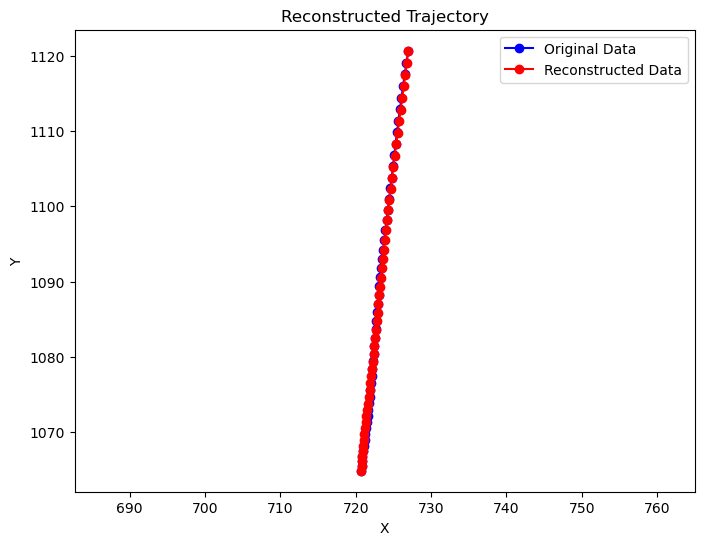

In [7]:
plt.figure(figsize=(8, 6))
# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
# num = 0
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='Original Data')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-o', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()

In [8]:

# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def AMDE_err(self,out,label):
        # 计算每个样本的误差
        error = ((out - label) ** 2).sum(dim=2).sqrt()
        # 提取最大值
        max_error, _ = error.max(dim=1)
        # 对最大值取平均
        amde = max_error.mean()
        return amde
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err1 = self.ADE_err(out,labels)
        loss_err1 = loss_err1.cpu().numpy()


        loss_err2 = self.AMDE_err(out,labels)
        loss_err2 = loss_err2.cpu().numpy()

        loss_err = [loss_err1,loss_err2]

        return loss_err

In [9]:
recon_tarj = Reconstruct_Traj()

err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('单点单向重构误差',err_two_point)

单点单向重构误差 [array(0.08921913, dtype=float32), array(0.20679162, dtype=float32)]
单点双向重构误差 [array(0.06965036, dtype=float32), array(0.14413266, dtype=float32)]
